In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
# Numpy
import numpy as np
from numpy import exp, log, minimum, sqrt
import math
# Scipy
from scipy import optimize
import pandas as pd
import seaborn as sns
import scipy
from scipy import interpolate

from os import listdir
from os.path import isfile, join
from astropy.io import fits
import galsim
from IPython.display import clear_output
import ngmix

from scipy.optimize import curve_fit
from scipy import stats
import sys
sys.path.append('/Users/zhangtianqing/Documents/Research/PSF_Rachel/HOMESim')
import homesm
import metasm
#import great3pipe
from astropy.io import fits
pd.set_option('display.max_columns', None)
import pickle

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100


In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def find_kurtosis_2(image):
    return galsim.hsm.FindAdaptiveMom(image).moments_rho4



class PSFSameSecondPairTest:
    
    def __init__(self, gal_type, gal_sigma,e1,e2,g1,g2,psf_type,psf_sigma,psf_e1,psf_e2,
                gal_flux=1.e2,pixel_scale = 0.1,sersicn = -1,subtract_intersection = True,
                is_self_defined_PSF = False , self_defined_PSF=None, self_define_PSF_model = None, 
                psf_sersicn = -1, metacal_method = None, mod_kol_radius_ratio = -1, GREAT3 = False, 
                cosmic_shear = None, great3_ind = None, great3_cat = None):
        
        #Define basic variables
        self.pixel_scale = pixel_scale        
        self.subtract_intersection = subtract_intersection        
        self.is_self_defined_PSF = is_self_defined_PSF
        self.metacal_method = metacal_method

        
        #Define galaxy
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.gal_flux=gal_flux
        self.e1 = e1
        self.e2 = e2
        self.g1 = g1
        self.g2 = g2
        self.cosmic_shear = galsim.Shear(g1 = g1, g2 = g2)
        self.e = np.sqrt(e1**2+e2**2)
        self.sersicn=sersicn
        self.e_truth = np.sqrt(e1**2+e2**2)

#         if gal_type == "gaussian":
#             self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
#         elif gal_type == "sersic":
#             self.gal_light = self.findAdaptiveSersic(gal_sigma,sersicn)
        if gal_type == 'gaussian':
            gaussian_profile = galsim.Gaussian(sigma = 1.0)
            gaussian_profile = self.toSize(gaussian_profile, self.gal_sigma)
            self.gal_light = gaussian_profile.withFlux(self.gal_flux)
        elif gal_type == 'sersic':
            sersic_profile = galsim.Sersic(sersicn, half_light_radius = 1.0)
            sersic_profile = self.toSize(sersic_profile, self.gal_sigma)
            self.gal_light = sersic_profile.withFlux(self.gal_flux)
   
        self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
        self.gal_rotate_light = self.gal_light.rotate(90 * galsim.degrees)
        
        self.gal_light = self.gal_light.shear(g1 = g1, g2 = g2)
        self.gal_rotate_light = self.gal_rotate_light.shear(g1 = g1, g2 = g2)
        
        if not is_self_defined_PSF:
            self.psf_type = psf_type
            self.psf_sigma = psf_sigma
            self.psf_model_sigma = psf_sigma
            self.psf_e1 = psf_e1
            self.psf_e2 = psf_e2
            self.psf_model_e1 = psf_e1
            self.psf_model_e2 = psf_e2

          
            if psf_type == 'gaussian':
                self.psf_light = galsim.Gaussian(flux = 1.0, sigma = self.psf_sigma)
                self.psf_light = self.toSize(self.psf_light, self.psf_sigma)
            elif psf_type == 'kolmogorov':
                self.psf_light  = galsim.Kolmogorov(flux = 1.0, half_light_radius = 1.0)
                self.psf_light = self.toSize(self.psf_light, self.psf_sigma)
                
                psf_model_light = 0.5*self.psf_light + 0.5*self.psf_light.expand(mod_kol_radius_ratio)
                
                new_sigma = galsim.hsm.FindAdaptiveMom(psf_model_light.drawImage(scale = self.pixel_scale, method = 'no_pixel')).moments_sigma*self.pixel_scale
                ratio = self.psf_sigma/new_sigma
                self.psf_model_light = psf_model_light.expand(ratio).withFlux(1.0)
                
                
            elif psf_type == 'opticalPSF':
                self.psf_light = galsim.OpticalPSF(1.0,flux = 1.0)
                self.psf_light = self.toSize(self.psf_light, self.psf_sigma)
            elif psf_type == 'sersic':
                self.psf_light = galsim.Sersic(psf_sersicn, half_light_radius = 1.0)
                self.psf_light = self.toSize(self.psf_light, self.psf_sigma)
                self.psf_model_light = galsim.Gaussian(flux = 1.0, sigma = self.psf_model_sigma)

            self.psf_light = self.psf_light.shear(e1=psf_e1, e2=psf_e2)
            self.psf_model_light = self.psf_model_light.shear(e1=self.psf_model_e1,e2=self.psf_model_e2)       
        else:
            self.psf_type = "self_define"
            truth_image = self_defined_PSF
            truth_psf = galsim.InterpolatedImage(truth_image,scale = pixel_scale)
            truth_measure = galsim.hsm.FindAdaptiveMom(truth_image)
            truth_sigma = truth_measure.moments_sigma

            model_image = self_define_PSF_model
            model_measure = galsim.hsm.FindAdaptiveMom(model_image)
            model_sigma = model_measure.moments_sigma
            model_psf = galsim.InterpolatedImage(model_image,scale = pixel_scale)

            delta_g1 = truth_measure.observed_shape.g1 - model_measure.observed_shape.g1
            delta_g2 = truth_measure.observed_shape.g2 - model_measure.observed_shape.g2

            this_ratio = truth_sigma/model_sigma


            model_psf_after = model_psf.expand(this_ratio)
            model_psf_after = model_psf_after.shear(g1 = delta_g1, g2 = delta_g2)


            self.psf_sigma = truth_sigma
            self.psf_model_sigma = self.psf_sigma
            self.psf_e1 = truth_measure.observed_shape.e1
            self.psf_model_e1 = self.psf_e1
            self.psf_e2 = truth_measure.observed_shape.e2
            self.psf_model_e2 = self.psf_e2
            self.psf_light = truth_psf
            self.psf_model_light = model_psf_after
            
            
    def get_intersection(self,metacal):
        image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        if metacal == False:
            results = galsim.hsm.EstimateShear(image,image_epsf)
            intersection = np.sqrt(results.corrected_e1**2+results.corrected_e2**2)-self.e_truth
            return intersection
        else:
            results = self.perform_metacal(image,image_epsf)
            intersection = np.sqrt(results['g_cal'].e1**2+results['g_cal'].e2**2) - self.e_truth
            return intersection
        

    def perc_bias(self,metacal = True):
        base_ori_r, base_ori_e = self.measure(metacal = metacal,rot = False, base = True)
        mod_ori_r, mod_ori_e = self.measure(metacal = metacal,rot = False, base = False)
        base_rot_r, base_rot_e = self.measure(metacal = metacal,rot = True, base = True)
        mod_rot_r, mod_rot_e = self.measure(metacal = metacal,rot = True, base = False)
        
        R_base = np.mean(np.array([base_ori_r,base_rot_r]),axis = 0).reshape(2,2)
        base_shape = np.mean(np.array([base_ori_e,base_rot_e]),axis = 0)
        g_base = np.matmul(np.linalg.inv(R_base),base_shape)
        
        R_mod = np.mean(np.array([mod_ori_r,mod_rot_r]),axis = 0).reshape(2,2)
        mod_shape = np.mean(np.array([mod_ori_e,mod_rot_e]),axis = 0)
        g_mod = np.matmul(np.linalg.inv(R_mod),mod_shape)
        print (g_mod[0] - g_base[0])/self.g1
        return (g_mod[0] - g_base[0])/self.g1
        
    def measure(self,metacal=True,rot = False, base = False):
        if base:
            image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        else:
            image_epsf = self.psf_model_light.drawImage(scale=self.pixel_scale)
            
        if rot:
            galaxy = self.gal_rotate_light
        else:
            galaxy = self.gal_light
        
        final = galsim.Convolve([galaxy,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        if metacal == False:
            results = galsim.hsm.EstimateShear(image,image_epsf)
            shape = galsim.Shear(e1 = results.corrected_e1, e2 = results.corrected_e2)
            return np.array([[1.0,0,0,1.0]]),np.array([shape.g1,shape.g2])
        else:
            results = self.perform_metacal(image,image_epsf)
            return results["R"].reshape((-1)), results["noshear"]
        
    def perform_metacal(self,image,image_epsf):
        metacal = metasm.metacal_shear_measure(image,image_epsf,great3 = True)
        metacal.measure_shear(self.metacal_method)
        results = metacal.get_results()
        return results
    
    def findAdaptiveSersic(self,sigma,n):
        good_half_light_re = bisect(Sersic_sigma,sigma/3,sigma*5,args=(n,self.pixel_scale,sigma))
        return galsim.Sersic(n=n,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,max(self.psf_sigma/5,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,max(self.psf_sigma/3,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
    
    def toSize(self, profile, sigma):
        true_sigma = galsim.hsm.FindAdaptiveMom(profile.drawImage(scale =self.pixel_scale,method = 'no_pixel')).moments_sigma*self.pixel_scale
        ratio = sigma/true_sigma
        new_profile = profile.expand(ratio)
        return new_profile
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale,method = 'no_pixel')
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_results(self,metacal = False):
        results = dict()
        
        results['shear_bias'] = self.perc_bias()
        
        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        results["gal_sigma"] = self.gal_sigma
        results["psf_sigma"] = self.psf_sigma
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["e"] = self.e
        results["sersicn"] = self.sersicn
        results["psf_e1"] = self.psf_e1
        results["psf_e2"] = self.psf_e2
        
        results["psf_model_sigma"] = self.psf_model_sigma
        results["psf_model_e1"] = self.psf_model_e1
        results["psf_model_e2"] = self.psf_model_e2

        
        
        results["psf_kurtosis"] = find_kurtosis_2(self.psf_light.drawImage(scale = self.pixel_scale))
        results["psf_model_kurtosis"] = find_kurtosis_2(self.psf_model_light.drawImage(scale = self.pixel_scale))
        results["kurtosis_perc_error"] = (results['psf_model_kurtosis']-results['psf_kurtosis'])/results['psf_model_kurtosis']
        
        return results
    
    
def do_tests(tests):
    testsresult=[]
    for i in range(len(tests)):
        test = PSFSameSecondPairTest(*tests[i][:-1],**tests[i][-1])
        results = test.get_results(metacal = True)
        testsresult.append(results)
        clear_output() 
        print ("Finished "+str(float((i+1))/len(tests)*100)+"%")
    return testsresult
    

In [11]:
class analysis:
    def __init__(self,main_cat_name,param_cat_name,df):
        self.main_cat = fits.open(main_cat_name)[1].data
        self.param_cat = fits.open(param_cat_name)[1].data
        self.df = df
        
        self.index = np.array(list(df["index"]))
        self.main_cat_crop = self.main_cat[self.index]
        self.param_cat_crop = self.param_cat[self.index]
        self.param_names = ["flux_radius", "zphot","use_bulgefit", "HLR"]
        
    def add_everything_to_df(self):
        
        params_dic = cosmos_cat.getParametricRecord(self.index)
        self.df["flux_radius"] = params_dic['flux_radius'].astype('float64')
        self.df['size_ratio'] = params_dic['sersicfit'][:,1].astype('float64')*0.03/df['psf_size']
        self.df["sersicn"] = params_dic['sersicfit'][:,2].astype('float64')
        self.df["hlr"] = params_dic['sersicfit'][:,1].astype('float64')
        self.df["q"] = params_dic['sersicfit'][:,3].astype('float64')
        self.df["zphot"] = params_dic['zphot'].astype('float64')
        self.df["use_bulgefit"] = params_dic['use_bulgefit'].astype('float64')
        self.df['magnitude'] = params_dic['mag_auto'].astype('float64')
    def bin_by(self, name, bin_number, by_num = False, ymax = None, ymin = None, bootstrap = True,df = None):
        
        
        if df is None:
            bin_df = self.df
        else:
            bin_df = df
            
        
        if ymax!=None:
            bin_df = bin_df[bin_df[name]<ymax]
        if ymin!=None:
            bin_df = bin_df[bin_df[name]>ymin]
            
        
        
        
        
        if by_num:
            
            unsortlist = np.array(list(bin_df[name]))
            sort_list = np.sort(unsortlist)
            bin_thresh = self.get_bin_thresh(bin_number, sort_list)
            print(bin_thresh)

            x_out = []
            y_out = []
            x_error = []
            y_error = []

            for i in range(len(bin_thresh)-1):
                print("bin ",i) 
                minthresh = bin_thresh[i]
                maxthresh = bin_thresh[i+1]
                sub_df =  bin_df[(bin_df[name] >= minthresh) & (bin_df[name] < maxthresh)]
                self.check_goodness_of_df(sub_df)
                if sub_df.shape[0]==0:
                    continue
                y_out.append(np.mean(np.array(list(sub_df[name]))))
                y_error.append(np.std(np.array(list(sub_df[name]))))
                
                x_ave, x_std = self.get_slope_bias(sub_df,bootstrap = bootstrap)
                
                x_out.append(x_ave)
                x_error.append(x_std)
                

            
            
        else:
            y_array = np.array(list(bin_df[name]))
            y_min = np.min(y_array)
            y_max = np.max(y_array)
            bin_width = (y_max-y_min)/bin_number

            x_out = []
            y_out = []
            x_error = []
            y_error = []

            for i in range(bin_number):
                bin_min = y_min+i*bin_width
                bin_max = y_min+(i+1)*bin_width

                sub_df = bin_df[(bin_df[name] >= bin_min) & (bin_df[name] <= bin_max)]

                if sub_df.shape[0]==0:
                    continue

                y_out.append(np.mean(np.array(list(sub_df[name]))))
                y_error.append(np.std(np.array(list(sub_df[name]))))
                x_ave, x_std = self.get_slope_bias(sub_df,bootstrap=bootstrap)
                x_out.append(x_ave)
                x_error.append(x_std)


        return x_out, y_out,x_error,y_error
    
    def get_truth_shear(self, df):
        
        g_truth = np.array(list(df["true_shear"]))
        true_shear = np.array([g_truth[0].g1,g_truth[0].g2])
        return true_shear
    
    def get_ensemble_response(self, df):
        
        
        R_base = np.array(list(df["R_base"]))
        R_base_ave = np.mean(R_base,axis= 0).reshape((2,2))
        
        R_mod = np.array(list(df["R_mod"]))
        R_mod_ave = np.mean(R_mod,axis= 0).reshape((2,2))
        
        return R_base_ave, R_mod_ave
        
    
    def get_shear(self, df, bootstrap = True):
        
        R_base, R_mod = self.get_ensemble_response(df)
        
        e_base = np.array(list(df["e_base"]))
        
        #e_base_ave = np.mean(e_base,axis= 0)
        
        if bootstrap:
            #e_base_ave, e_base_std = self.bootstrap(e_base)
            
            
            g_base, g_base_std = self.bootstrap_shear(np.array(list(df['R_base'])),np.array(list(df['e_base'])))
            #print g_base,g_base_std
        else:
            e_base_ave = np.mean(e_base,axis= 0)
            e_base_std = np.std(e_base,axis = 0)
            g_base = np.matmul(np.linalg.inv(R_base),e_base_ave)
            g_base_std = np.matmul(np.linalg.inv(R_base),e_base_std)/np.sqrt(e_base.shape[0])

        #g_base = np.matmul(np.linalg.inv(R_base),e_base_ave)
        #g_base_std = np.matmul(np.linalg.inv(R_base),e_base_std)/np.sqrt(e_base.shape[0])
        #print g_base,g_base_std
        
        e_mod = np.array(list(df["e_mod"]))
        #e_mod_ave = np.mean(e_mod,axis= 0)

        if bootstrap:
            #e_mod_ave, e_mod_std = self.bootstrap(e_mod)
            g_mod, g_mod_std = self.bootstrap_shear(np.array(list(df['R_mod'])),np.array(list(df['e_mod'])))

        else:
            e_mod_ave = np.mean(e_mod,axis= 0)
            e_mod_std = np.std(e_mod,axis = 0)            
            g_mod = np.matmul(np.linalg.inv(R_mod),e_mod_ave)
            g_mod_std = np.matmul(np.linalg.inv(R_mod),e_mod_std)/np.sqrt(e_mod.shape[0])
        #g_mod = np.matmul(np.linalg.inv(R_mod),e_mod_ave)
        #g_mod_std = np.matmul(np.linalg.inv(R_mod),e_mod_std)/np.sqrt(e_mod.shape[0])
                
        return g_base,g_base_std,g_mod,g_mod_std
    
    def get_shear_perc_bias(self, df,bootstrap = True):
        
        g_base,g_base_std,g_mod,g_mod_std = self.get_shear(df, bootstrap = bootstrap)
        g_truth = self.get_truth_shear(df)
        
        g_base_m = np.linalg.norm(g_base)
        g_mod_m = np.linalg.norm(g_mod)
        g_base_std_m = np.linalg.norm(g_base_std)
        g_mod_std_m = np.linalg.norm(g_mod_std)
        
        
#         multiplicative_bias = g_mod_m/g_base_m-1.0
#         multiplicative_bias_std = np.sqrt((g_base_std_m/g_mod_m)**2+(g_mod_std_m*g_base_m/g_mod_m**2)**2)
        
#         print multiplicative_bias, multiplicative_bias_std
        
        multiplicative_bias = g_mod[1]/g_base[1]-1.0
        multiplicative_bias_std = np.sqrt((g_mod_std[1]/g_base[1])**2+(g_base_std[1]*g_mod[1]/g_base[1]**2)**2)
        
        
#         bias = g_mod - g_base
#         bias_std = g_mod_std
#         g_truth_m = np.sqrt(g_truth[0]**2+g_truth[1]**2)
        
#         perc_bias = np.sqrt(bias[0]**2+bias[1]**2)/g_truth_m
        
#         perc_bias_std = np.sqrt(bias_std[0]**2+bias_std[1]**2)/g_truth_m
        return multiplicative_bias, multiplicative_bias_std
    
    def get_slope_bias(self, df,bootstrap=True):
        
        perc_bias,perc_bias_std = self.get_shear_perc_bias(df,bootstrap = bootstrap)
        ave_model_kurtosis = np.mean(np.array(list(df["model_kurtosis"])))
        ave_truth_kurtosis = np.mean(np.array(list(df["truth_kurtosis"])))
        
        perc_kurtosis_bias = (ave_model_kurtosis-ave_truth_kurtosis)/ave_truth_kurtosis
        
#         print perc_kurtosis_bias
#         print perc_bias
        
        return perc_bias/perc_kurtosis_bias, perc_bias_std/perc_kurtosis_bias
        
        
        
    def get_perc_kurtosis_bias(self, df):
        ave_model_kurtosis = np.mean(np.array(list(df["model_kurtosis"])))
        ave_truth_kurtosis = np.mean(np.array(list(df["truth_kurtosis"])))
        
        perc_kurtosis_bias = (ave_model_kurtosis-ave_truth_kurtosis)/ave_truth_kurtosis
        return perc_kurtosis_bias
        
    def bootstrap(self, data, n=None, iteration = 10000):
        
        N = data.shape[0]
        if n==None:
            n = N
        #plt.hist(data[:,0],color = 'red')
        #plt.show()
        mean_list = []
        
        if len(data)%2==1:
            print("Warning: data has odd number of entries")
        
        for i in range(iteration):
            index_list = self.get_index_w_rot(N,n)
            instance = data[index_list]
            mean_list.append(np.mean(instance,axis = 0))

        mean_list = np.array(mean_list)
#         plt.hist(mean_list[:,0])
#         plt.show()
        return np.mean(mean_list,axis = 0), np.std(mean_list, axis = 0)

    def bootstrap_shear(self, R,shear, n=None, iteration = 10000):
        
        N = R.shape[0]
        if n==None:
            n = N
        #plt.hist(data[:,0],color = 'red')
        #plt.show()
        mean_list = []
        
        if len(R)%2==1:
            print("Warning: data has odd number of entries")
        
        for i in range(iteration):
            index_list = self.get_index_w_rot(N,n)
            Rins = R[index_list]
            shearins = shear[index_list]
            g_instance = np.matmul(np.linalg.inv(np.mean(Rins,axis = 0).reshape(2,2)), np.mean(shearins,axis = 0) )
            mean_list.append(g_instance)
            
        
        
        mean_list = np.array(mean_list)
#         plt.hist(mean_list[:,0])
#         plt.show()
        return np.mean(mean_list,axis = 0), np.std(mean_list, axis = 0)
    
    def get_index_w_rot(self, N, n):
        index_list = np.random.randint( N/2, size=n//2)
        index_list = np.repeat(2*index_list,2)
        odd = np.tile(np.array([0,1]),n//2)
        index_list = index_list + odd
        return index_list
            
    def get_random_subdf(self, df, n):
        index_list = np.random.randint(df, size=n)
        
        
    def calc_individual_shape(self):
        R_base_ave, R_mod_ave = self.get_ensemble_response(self.df)
        g_base = np.matmul(np.linalg.inv(R_base_ave),np.array(list(self.df["e_base"])).T).T
        g_mod = np.matmul(np.linalg.inv(R_mod_ave),np.array(list(self.df["e_mod"])).T).T
        self.df["g_base"] = g_base[:,1]
        self.df["g_mod"] = g_mod[:,1]
        self.df["m"] = (g_mod[:,1]/g_base[:,1] -1.0)
        
    def cut_insane_m(self):
        self.df = self.df[self.df["m"]>-0.1]
        
    def outlier_average(self,data,outlierConstant = 5):
        print("original", data.shape)
        print(data.min(), data.max())
        upper_quartile = np.percentile(data, 75)
        lower_quartile = np.percentile(data, 25)
        IQR = (upper_quartile - lower_quartile) * outlierConstant
        quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
        
        result = data[np.where((data >= quartileSet[0]) & (data <= quartileSet[1]))]
        print("after", result.shape)
        print( result.min(), result.max())
        return(result)
    
    
    def check_goodness_of_df(self,df):
        n = df.shape[0]
        index_list = np.array(list(df["index"]))
        if n%2!=0:
            print( "Wrong!")
        for i in range(n//2):
            if index_list[2*i]!=index_list[2*i+1]:
                print ("Wrong!")
                print( 2*i, index_list[2*i],2*i+1,index_list[2*i+1])
                return
        #print "Goooood!", len(index_list)
        
    def get_bin_thresh(self, bin_number, array):
        
        y_length = len(array)
        bin_length = y_length//bin_number
        threshlist = []
        threshlist.append(array[0])
        for i in range(bin_number):
            threshlist.append(array[min(len(array)-1,(i+1)*bin_length)])
        thresh_array = np.array(threshlist)
        unique_array = np.unique(thresh_array)
        if len(thresh_array)!=len(unique_array):
            print( "Warning, bin number has been reduced since enormous amount of same value")
        return unique_array
        
        
    def additional_cut(self, cut_var_list, cut_range):
        if len(cut_var_list)!= len(cut_range):
            print("length of variable name and range are not equal!")
            return
        
        for varname,cutrange in zip(cut_var_list,cut_range):
            self.df = self.df[self.df[varname]>cutrange[0]]
            self.df = self.df[self.df[varname]<cutrange[1]]
        

In [12]:
cat_file_name = 'real_galaxy_catalog_25.2.fits'
catparam_file_name = 'real_galaxy_catalog_25.2_fits.fits'
dir = "COSMOS_25.2_training_sample"
cosmos_cat = galsim.COSMOSCatalog(cat_file_name, dir=dir)

In [30]:
df = pd.read_pickle("Outputs252/kol1d1shear2/kol1d1shear0d01wR2.pkl")
#df = pd.read_pickle("Outputs252_0d3_moffat/mof1d1shear2/mof1d1shear0d01wR2.pkl")

In [31]:
print(df.shape)

(108560, 12)


In [32]:
dir_cat = "COSMOS_25.2_training_sample/"
ana = analysis(dir_cat+cat_file_name, dir_cat+catparam_file_name, df)
ana.add_everything_to_df()
ana.calc_individual_shape()
ana.additional_cut(['R2'],[(0.3,9999)])
#ana.cut_insane_m()


In [33]:
size_ratio = ana.df['size_ratio']
np.save('size_ratio_array.npy',size_ratio, )

In [34]:
ana.df.head()

,index,true_shear,truth_kurtosis,model_kurtosis,R_base,e_base,R_mod,e_mod,psf_size,gal_size,sersic_index,R2,flux_radius,size_ratio,sersicn,hlr,q,zphot,use_bulgefit,magnitude,g_base,g_mod,m
2,2,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9420960385648464, 0.08096446601157103, 0.08...","[-0.24083040117568713, 0.17452936250894355]","[0.9419175078725486, 0.08082308746236028, 0.08...","[-0.2410496227965338, 0.17468833446647963]",0.35,0.272753,0.938620,0.728460,14.171382,1.502706,0.938620,17.531571,0.533826,1.0190,0.0,23.126625,0.190492,0.190323,-0.000887
3,2,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9355058142482331, 0.07224181452188533, 0.07...","[0.2423628824444475, -0.1545536361224814]","[0.9353382157748946, 0.07211751024215063, 0.07...","[0.24258421802391125, -0.15469481413518832]",0.35,0.272753,0.938620,0.728460,14.171382,1.502706,0.938620,17.531571,0.533826,1.0190,0.0,23.126625,-0.168677,-0.168528,-0.000882
4,3,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9912868819004883, -0.11206391991362696, -0....","[0.19855929609009323, 0.26944775856513603]","[0.9911478292484593, -0.11184860218632908, -0....","[0.19873393469882233, 0.26968495771540557]",0.35,0.309124,0.469744,0.733083,13.591013,1.464821,0.469744,17.089582,0.489390,1.0312,0.0,23.618082,0.294339,0.294062,-0.000941
5,3,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9804028754113056, -0.105476834137197, -0.10...","[-0.20075112625476713, -0.2509142562785587]","[0.9802525242258067, -0.10527391154305232, -0....","[-0.2009287684971912, -0.2511363872081724]",0.35,0.309124,0.469744,0.733083,13.591013,1.464821,0.469744,17.089582,0.489390,1.0312,0.0,23.618082,-0.274100,-0.273844,-0.000936
8,5,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[1.0481754554320142, 0.11816148520246983, 0.11...","[-0.1484904916938232, 0.38904338204324]","[1.048615943901643, 0.11622712174746141, 0.115...","[-0.1483101345848041, 0.3885712535865492]",0.35,0.130929,0.790174,0.444401,8.664006,0.800484,0.790174,9.338980,0.374867,1.6244,0.0,23.807924,0.424794,0.423512,-0.003018


In [12]:
HLR = ana.df['hlr']
flux_radius = ana.df['flux_radius']

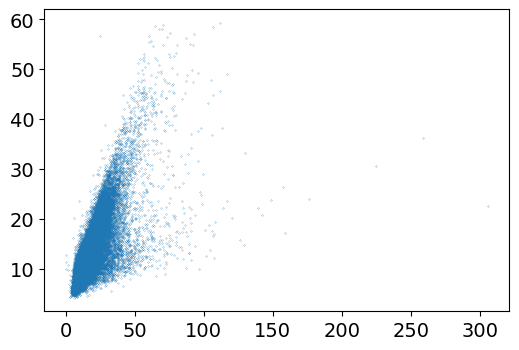

In [13]:
plt.scatter(HLR, flux_radius,s = 0.01)

In [11]:
size = ana.df

In [23]:
df1 = ana.df[ana.df['R2']>0.3]
df2 = ana.df[ana.df['R2']<0.3]

In [24]:
R2_1 = df1['R2']
R2_2 = df2['R2']

In [25]:
sigma_1 = df1['gal_size']
sigma_2 = df2['gal_size']

In [26]:
flux_size_1 = df1['hlr'] * 0.03
flux_size_2 = df2['hlr'] * 0.03

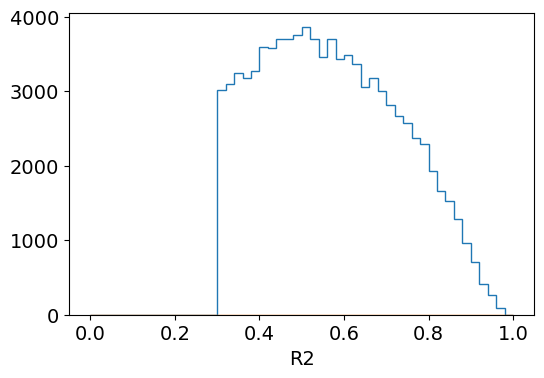

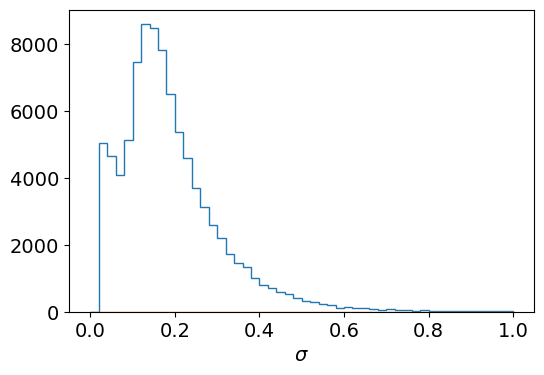

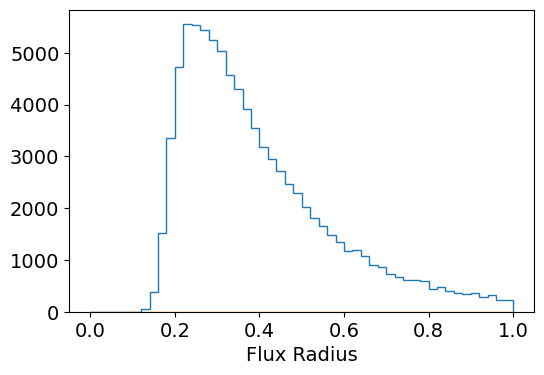

In [27]:
plt.hist(R2_1,bins = 50 ,range = (0,1),histtype='step',)
plt.hist(R2_2,bins = 50 ,range = (0,1),histtype='step',)

plt.xlabel('R2')
plt.show()

plt.hist(sigma_1,bins = 50, range = (0,1.0),histtype='step',)
plt.hist(sigma_2,bins = 50, range = (0,1.0),histtype='step',)
plt.xlabel(r'$\sigma$')
plt.show()


plt.hist(flux_size_1, bins = 50, range = (0,1.0),histtype='step',)
plt.hist(flux_size_2, bins = 50, range = (0,1.0),histtype='step',)
plt.xlabel('Flux Radius')
plt.show()

In [18]:
sigma_list = np.array(ana.df[ana.df['gal_size']>0.286]['gal_size'])
print np.mean(sigma_list)

0.397913982985024


In [22]:
print ana.df.shape

(81596, 22)


In [32]:
(2.0922-2.0889)/2.0922

0.001577287066245989

In [80]:
ana.df.head(200)

,index,true_shear,truth_kurtosis,model_kurtosis,R_base,e_base,R_mod,e_mod,psf_size,gal_size,sersic_index,R2,flux_radius,size_ratio,sersicn,hlr,q,zphot,use_bulgefit,magnitude,g_base,g_mod,m
2,2,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.942266494076134, 0.08090919438202976, 0.080...","[-0.24084132586724313, 0.17453288498895164]","[0.9420933009070293, 0.08076641317006639, 0.08...","[-0.24106101253770745, 0.17469172544425382]",0.35,0.272753,0.938620,0.730516,14.171382,1.214690,0.938620,17.531571,0.533826,1.0190,0.0,23.126625,0.190484,0.190318,-0.000873
3,2,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9348899752122816, 0.07195030285362669, 0.07...","[0.24237117425102325, -0.1545590464162631]","[0.9347576131199478, 0.07180244259639701, 0.07...","[0.2425935314192059, -0.15470004741206214]",0.35,0.272753,0.938620,0.730516,14.171382,1.214690,0.938620,17.531571,0.533826,1.0190,0.0,23.126625,-0.168672,-0.168525,-0.000868
4,3,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9908083847575938, -0.11233597277737761, -0....","[0.19857143413135356, 0.26945474355171667]","[0.9906987978047801, -0.11212281024206294, -0....","[0.19874678149297062, 0.2696935705417244]",0.35,0.309124,0.469744,0.735143,13.591013,1.164944,0.469744,17.089582,0.489390,1.0312,0.0,23.618082,0.294340,0.294066,-0.000928
5,3,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.9795157400836058, -0.1057188244133575, -0.1...","[-0.20075301729847128, -0.2508978049817863]","[0.9802277106216728, -0.10527996672711482, -0....","[-0.20092963456367807, -0.2511354555799636]",0.35,0.309124,0.469744,0.735143,13.591013,1.164944,0.469744,17.089582,0.489390,1.0312,0.0,23.618082,-0.274076,-0.273838,-0.000868
8,5,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[1.0482020040688127, 0.11816423522157393, 0.11...","[-0.14849200928837036, 0.38904862615761276]","[1.0484109110289879, 0.11645221149544638, 0.11...","[-0.14829725994746878, 0.38855542710810265]",0.35,0.130929,0.790174,0.447282,8.664006,0.742629,0.790174,9.338980,0.374867,1.6244,0.0,23.807924,0.424782,0.423481,-0.003062
9,5,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[1.0331395705548905, 0.1153283660459109, 0.115...","[0.15082225570088287, -0.3732470165460856]","[1.0336483524103615, 0.11344108327073499, 0.11...","[0.15063458491180196, -0.3727815691504613]",0.35,0.130929,0.790174,0.447282,8.664006,0.742629,0.790174,9.338980,0.374867,1.6244,0.0,23.807924,-0.407525,-0.406286,-0.003041
10,7,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.8749678162110808, -0.1472758752114542, -0.1...","[0.3562725666438089, 0.19708953233622073]","[0.8743152850080177, -0.1472053778170404, -0.1...","[0.356558171715143, 0.197249353482993]",0.35,0.438059,0.308959,0.857149,16.072845,1.377672,0.308959,25.558361,0.412475,1.4328,0.0,24.153313,0.215387,0.215167,-0.001019
11,7,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.8641946333711681, -0.1323064008070543, -0.1...","[-0.35907565599770763, -0.17579327122976846]","[0.8640683021506446, -0.1323476969045806, -0.1...","[-0.3593556183592341, -0.17594012886453972]",0.35,0.438059,0.308959,0.857149,16.072845,1.377672,0.308959,25.558361,0.412475,1.4328,0.0,24.153313,-0.192132,-0.191940,-0.000998
12,8,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.7270718575399571, -0.09004728271714904, -0....","[-0.31935831270577436, -0.11437279092594206]","[0.7332143525810936, -0.08798700974195633, -0....","[-0.31821806532464275, -0.11394861338038884]",0.35,0.126233,0.473940,0.334192,6.306777,0.540581,0.473940,7.531346,0.418058,0.2065,0.0,25.044474,-0.125042,-0.124348,-0.005545
13,8,"galsim.Shear(g1=0.0,g2=0.01)",2.088167,2.091347,"[0.7354677934768517, -0.1000915859425966, -0.0...","[0.3176944806907238, 0.13424911603441983]","[0.7424559618919746, -0.09469857578428692, -0....","[0.31656396927620056, 0.1335383964144885]",0.35,0.126233,0.473940,0.334192,6.306777,0.540581,0.473940,7.531346,0.418058,0.2065,0.0,25.044474,0.146746,0.145702,-0.007119


In [63]:
fluxrad = np.array(list(ana.df['gal_size']))

In [64]:
fluxrad.dtype

dtype('float64')

In [65]:
print ana.outlier_average(np.array(list(ana.df["e_mod"]))[:,0],outlierConstant = 2)
print np.array(list(ana.df["e_mod"]))[:,0].min()

original (90404,)
-0.7540075787481246 0.7545536292609051
after (90404,)
-0.7540075787481246 0.7545536292609051
[-0.24106101  0.24259353  0.19874678 ...  0.03294991 -0.27969391
  0.28138019]
-0.7540075787481246


In [14]:
num_list = [34,100,334,1000,3334,10000,33334]
base_ave_list = []
base_std_list = []
for num in num_list:
    ave,std = ana.get_shear(ana.df[0:num],bootstrap=False)[0:2]
    base_ave_list.append(ave)
    base_std_list.append(std)
base_ave_list=np.array(base_ave_list)
base_std_list=np.array(base_std_list)

In [15]:
num_list = [34,100,334,1000,3334,10000,33334]
mod_ave_list = []
mod_std_list = []
for num in num_list:
    ave,std = ana.get_shear(ana.df[0:num],bootstrap=False)[2:]
    mod_ave_list.append(ave)
    mod_std_list.append(std)
mod_ave_list=np.array(mod_ave_list)
mod_std_list=np.array(mod_std_list)

Text(0.5,1,'Bias of Shear w/ Shape Noise')

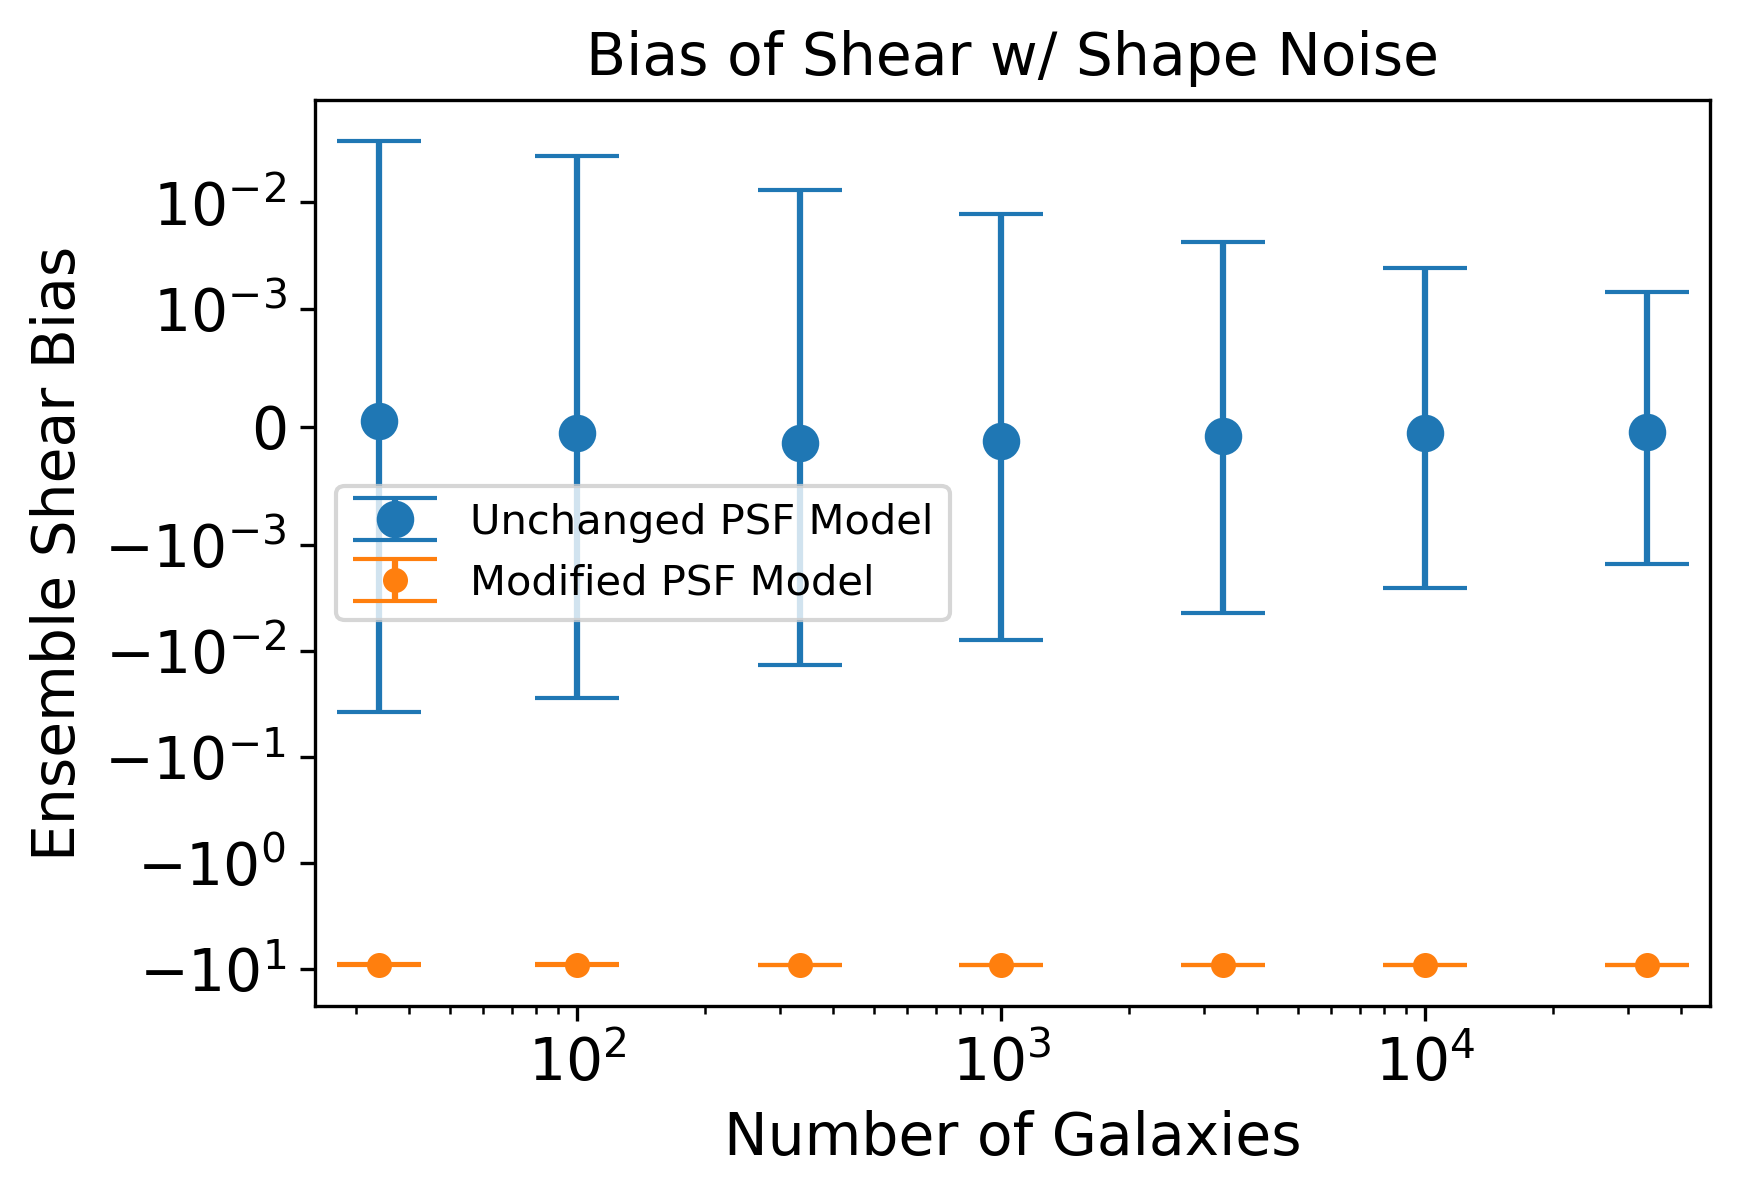

In [16]:
plt.errorbar(num_list, (base_ave_list[:,0]-0.004)/0.004, base_std_list[:,0], fmt = 'o', markersize=8, capsize=10,label = "Unchanged PSF Model")
plt.errorbar(num_list, (mod_ave_list[:,0]-0.04)/0.004, mod_std_list[:,0], fmt = 'o', markersize=5, capsize=10, label = "Modified PSF Model")
plt.xscale("log")
plt.yscale("symlog", linthreshy=1.e-3)
plt.xlabel('Number of Galaxies')
plt.ylabel('Ensemble Shear Bias')
plt.legend()
plt.title("Bias of Shear w/ Shape Noise")

In [81]:
num_list = [34,100,334,1000,3334,10000,33334]
base_ave_list_bos = []
base_std_list_bos = []
mod_ave_list_bos = []
mod_std_list_bos = []

R_base_ave, R_mod_ave = ana.get_ensemble_response(ana.df)
g_base = np.matmul(np.linalg.inv(R_base_ave),np.array(list(ana.df["e_base"])).T).T
g_mod = np.matmul(np.linalg.inv(R_mod_ave),np.array(list(ana.df["e_mod"])).T).T
for num in num_list:
    g_sub_base,g_sub_base_std = ana.bootstrap(g_base,  n=num)
    g_sub_mod,g_sub_mod_std = ana.bootstrap(g_mod,  n=num)
    base_ave_list_bos.append(g_sub_base)
    base_std_list_bos.append(g_sub_base_std)
    mod_ave_list_bos.append(g_sub_mod)
    mod_std_list_bos.append(g_sub_mod_std)
    
base_ave_list_bos=np.array(base_ave_list_bos)
base_std_list_bos=np.array(base_std_list_bos)
mod_ave_list_bos=np.array(mod_ave_list_bos)
mod_std_list_bos=np.array(mod_std_list_bos)

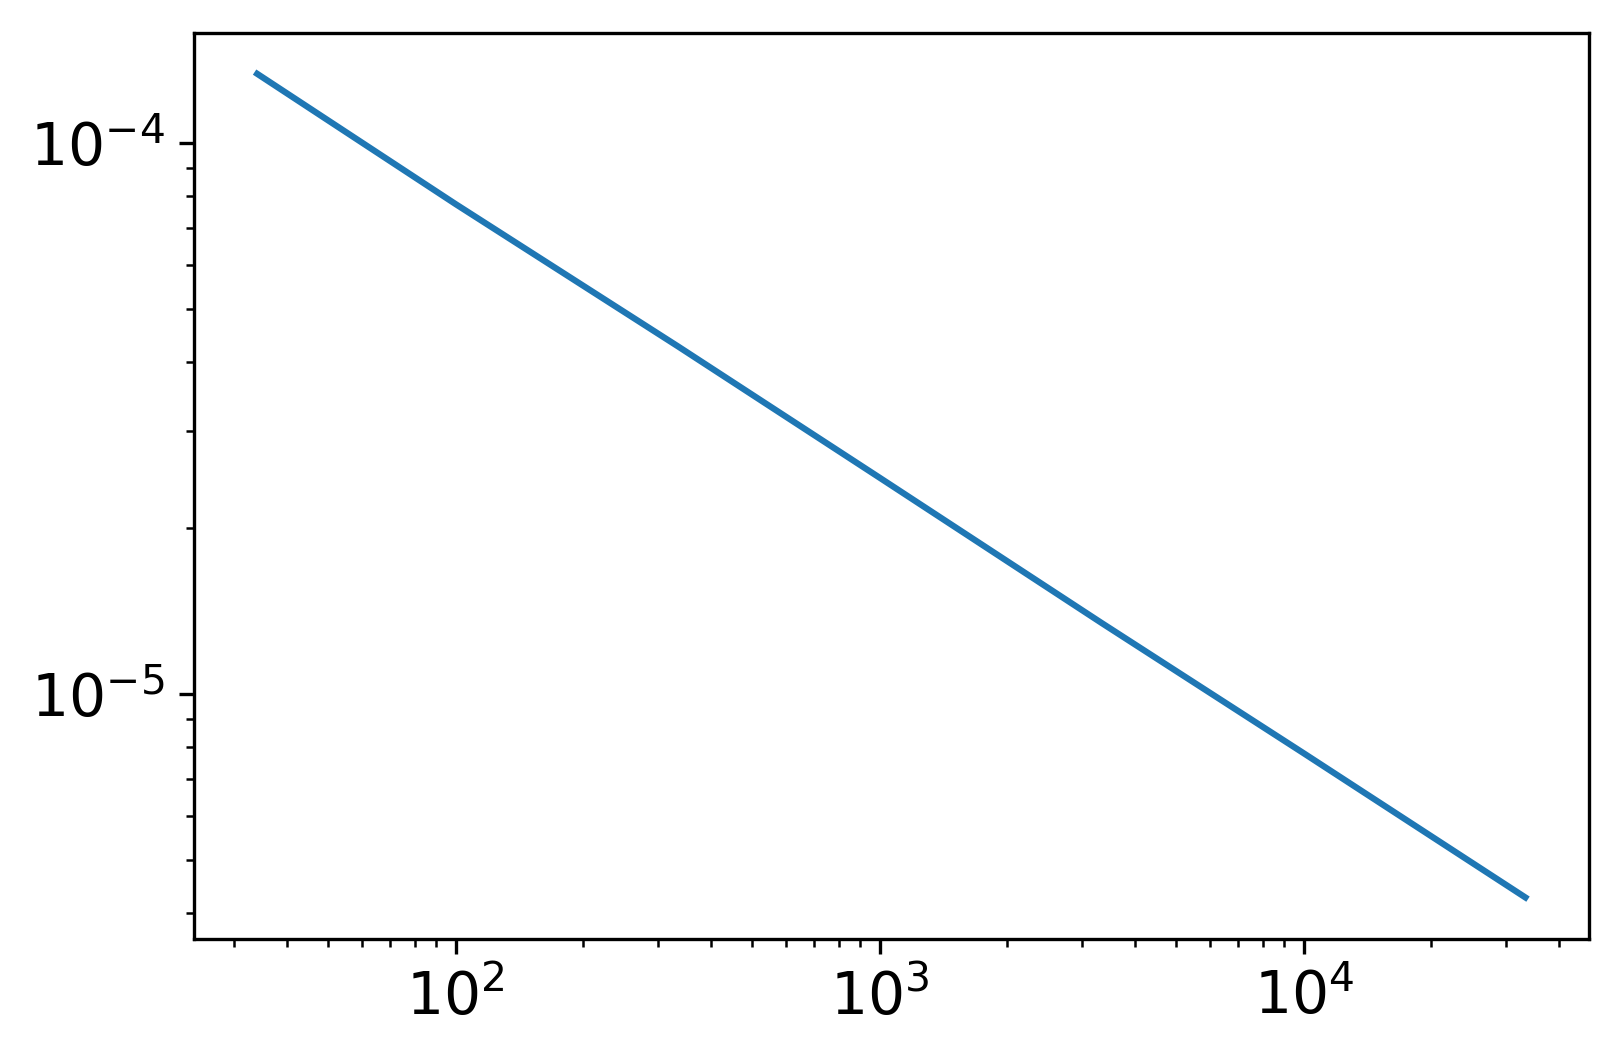

In [82]:
plt.loglog(num_list, base_std_list_bos[:,0])

Text(0.5,1,'Bias of Shear w/ Bootstrap')

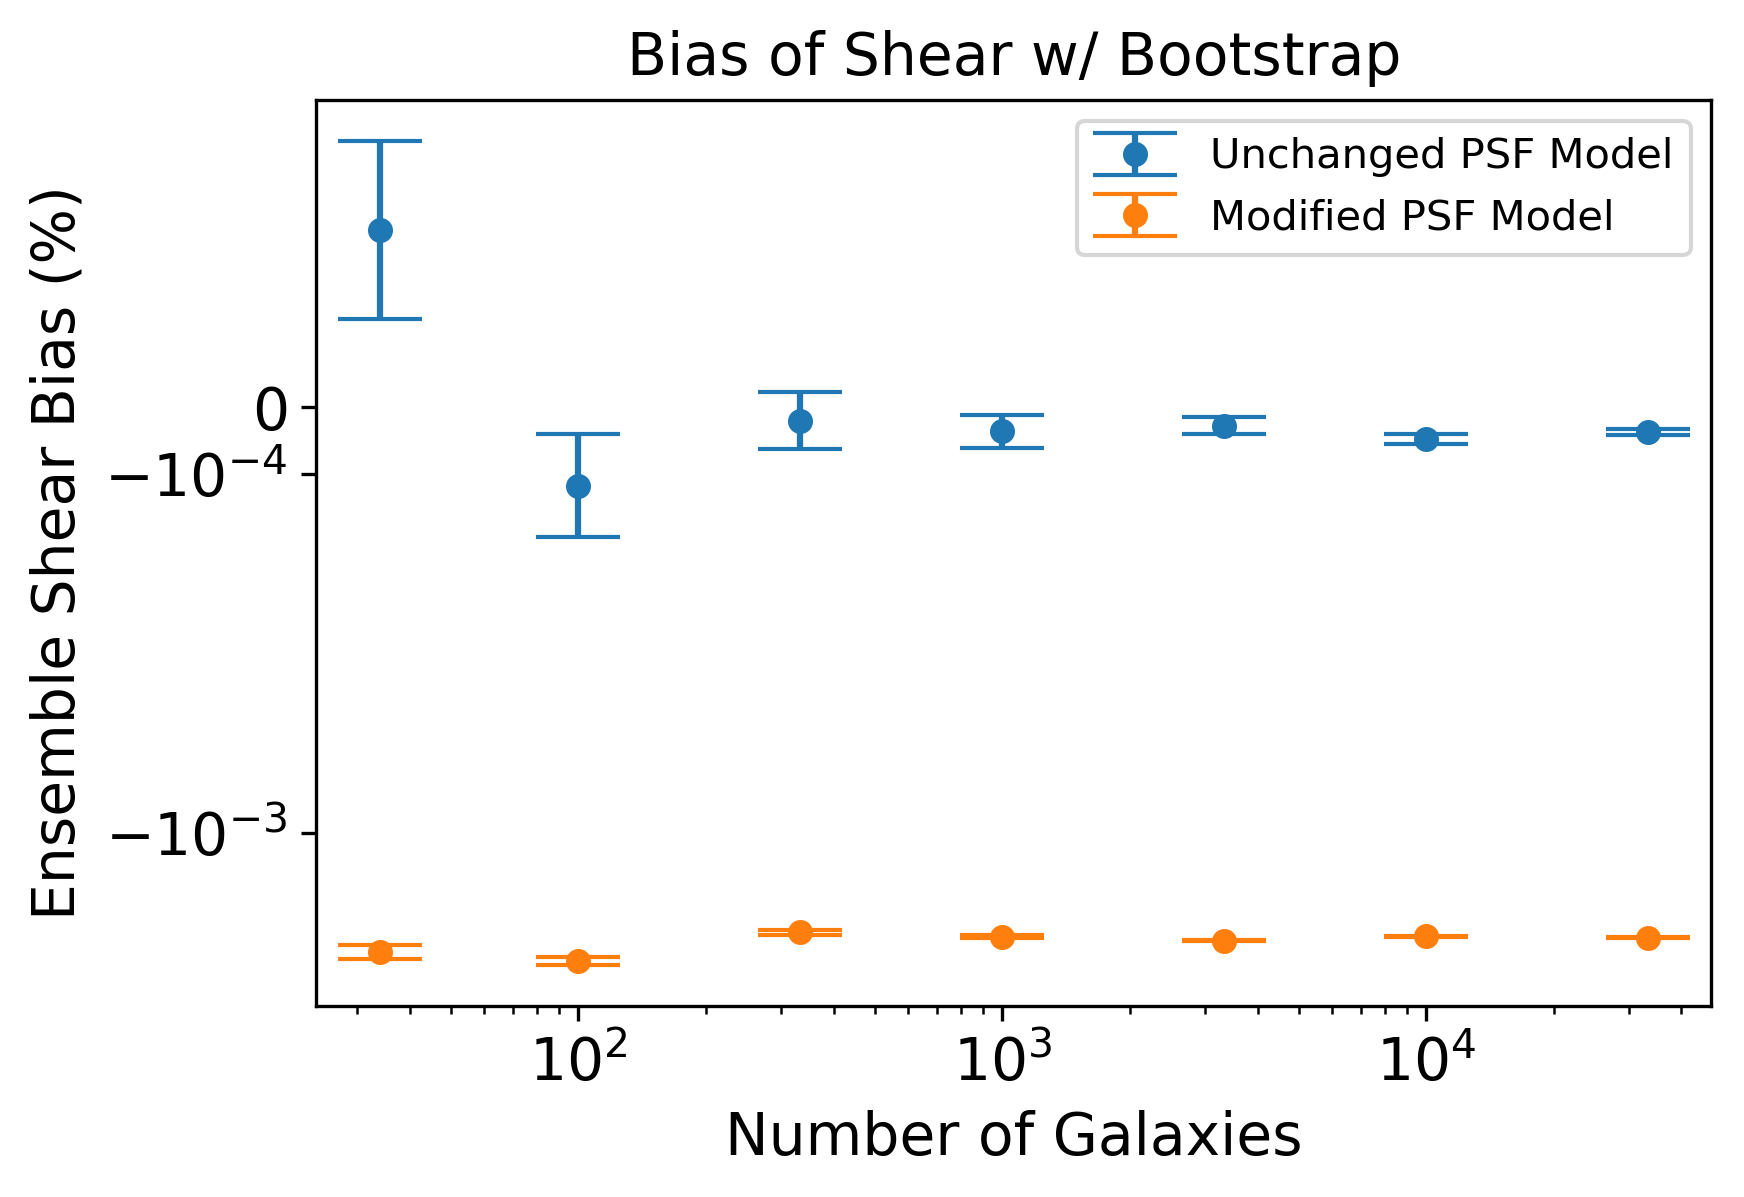

In [83]:
plt.errorbar(num_list, (base_ave_list_bos[:,0]-0.004)/0.004, base_std_list_bos[:,0], fmt = 'o', markersize=5, capsize=10,label = "Unchanged PSF Model")
plt.errorbar(num_list, (mod_ave_list_bos[:,0]-0.004)/0.004, mod_std_list_bos[:,0], fmt = 'o', markersize=5, capsize=10, label = "Modified PSF Model")
#plt.plot(num_list,base_std_list_bos[:,0])
plt.xscale("log")
plt.yscale("symlog", linthreshy=5.e-4)
#plt.yscale("linear")
plt.xlabel('Number of Galaxies')
plt.ylabel('Ensemble Shear Bias (%)')
plt.legend()
plt.title("Bias of Shear w/ Bootstrap")

In [84]:
m = g_mod/g_base - 1.0
m1 = m[:,0]

print np.mean(m1)
print np.median(m1)

-0.0026581590127660796
-0.0012083295751550982


In [49]:
T_psf = np.array(list(ana.df['psf_size']))**2
T_gal = np.array(list(ana.df['gal_size']))**2
R2 = 1 - T_psf/(T_gal+T_psf)



In [50]:
print T_psf.shape

(99252,)


In [57]:
print np.max(R2)

0.9549227763064783


(array([0.000e+00, 9.176e+03, 7.272e+03, 7.214e+03, 7.900e+03, 8.828e+03,
        8.484e+03, 7.804e+03, 7.232e+03, 5.940e+03, 4.942e+03, 4.234e+03,
        3.352e+03, 2.874e+03, 2.368e+03, 1.994e+03, 1.566e+03, 1.324e+03,
        1.212e+03, 9.100e+02, 7.180e+02, 6.400e+02, 5.380e+02, 4.820e+02,
        3.740e+02, 2.800e+02, 2.440e+02, 2.080e+02, 1.900e+02, 1.120e+02,
        1.140e+02, 1.020e+02, 9.800e+01, 6.800e+01, 5.200e+01, 6.200e+01,
        4.200e+01, 5.200e+01, 2.600e+01, 4.200e+01, 2.000e+01, 2.200e+01,
        1.400e+01, 1.400e+01, 1.400e+01, 2.000e+01, 1.200e+01, 8.000e+00,
        1.000e+01, 1.200e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects

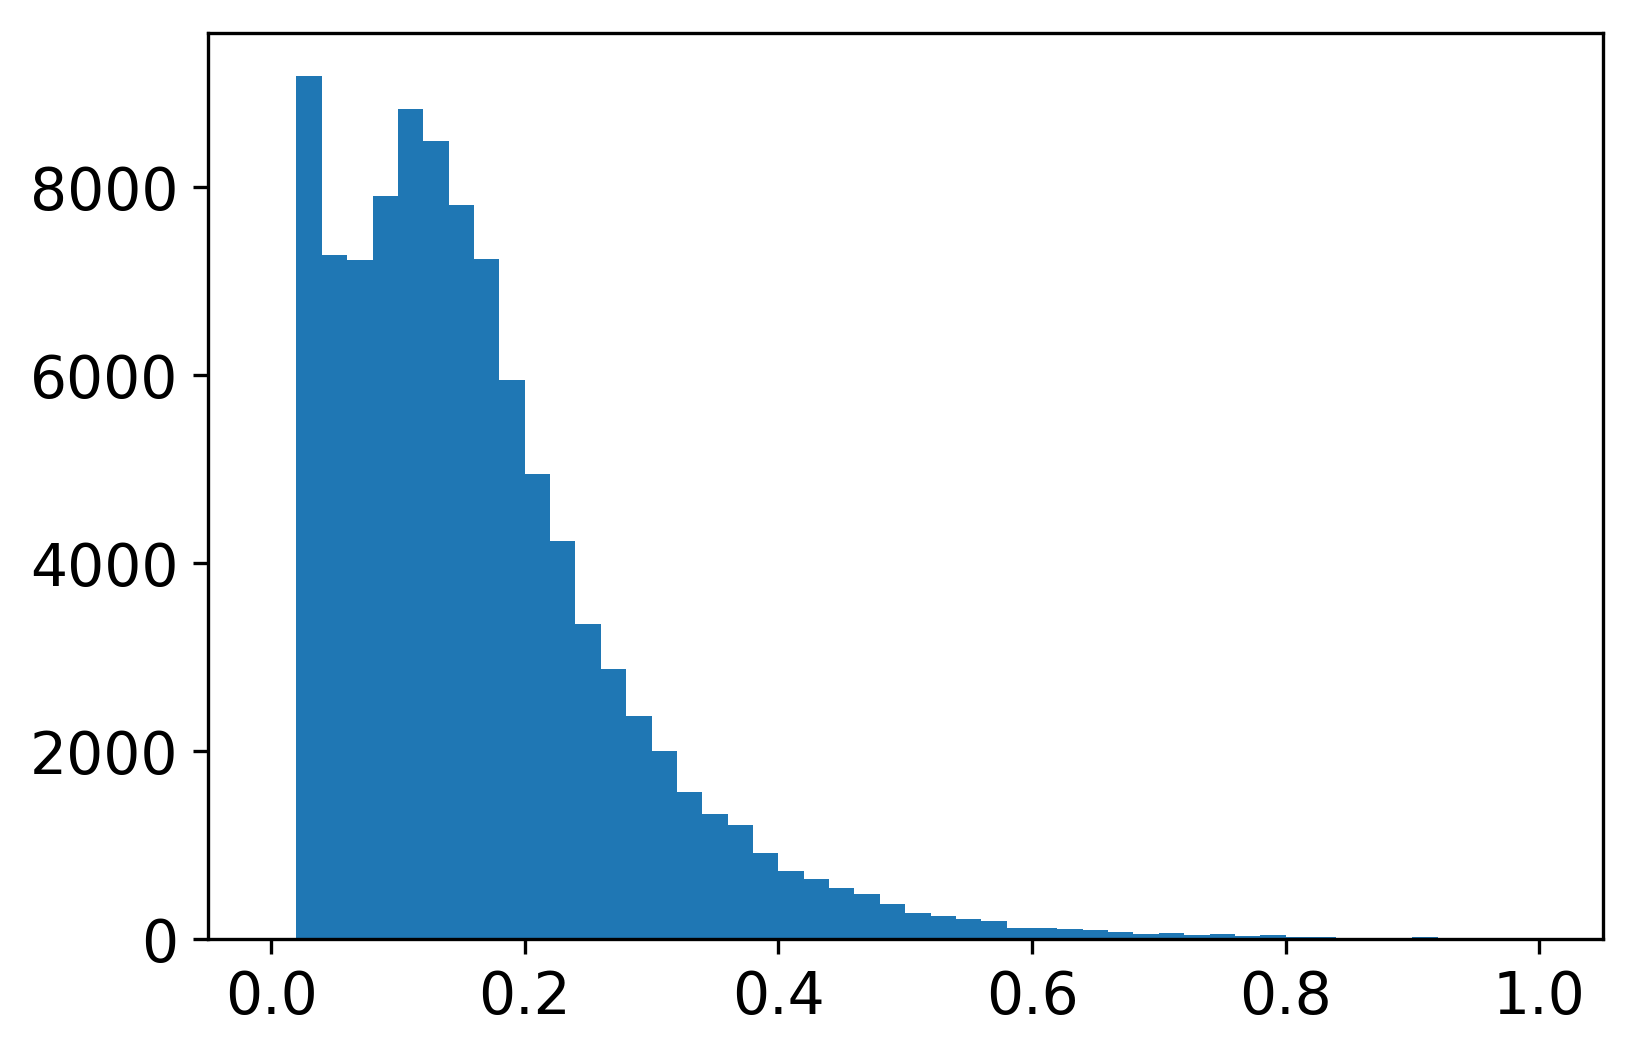

In [29]:
gal_size = np.array(list(ana.df['gal_size']))
plt.hist(gal_size,range =[0,1],bins = 50 )


Text(0.5,0,'R2')

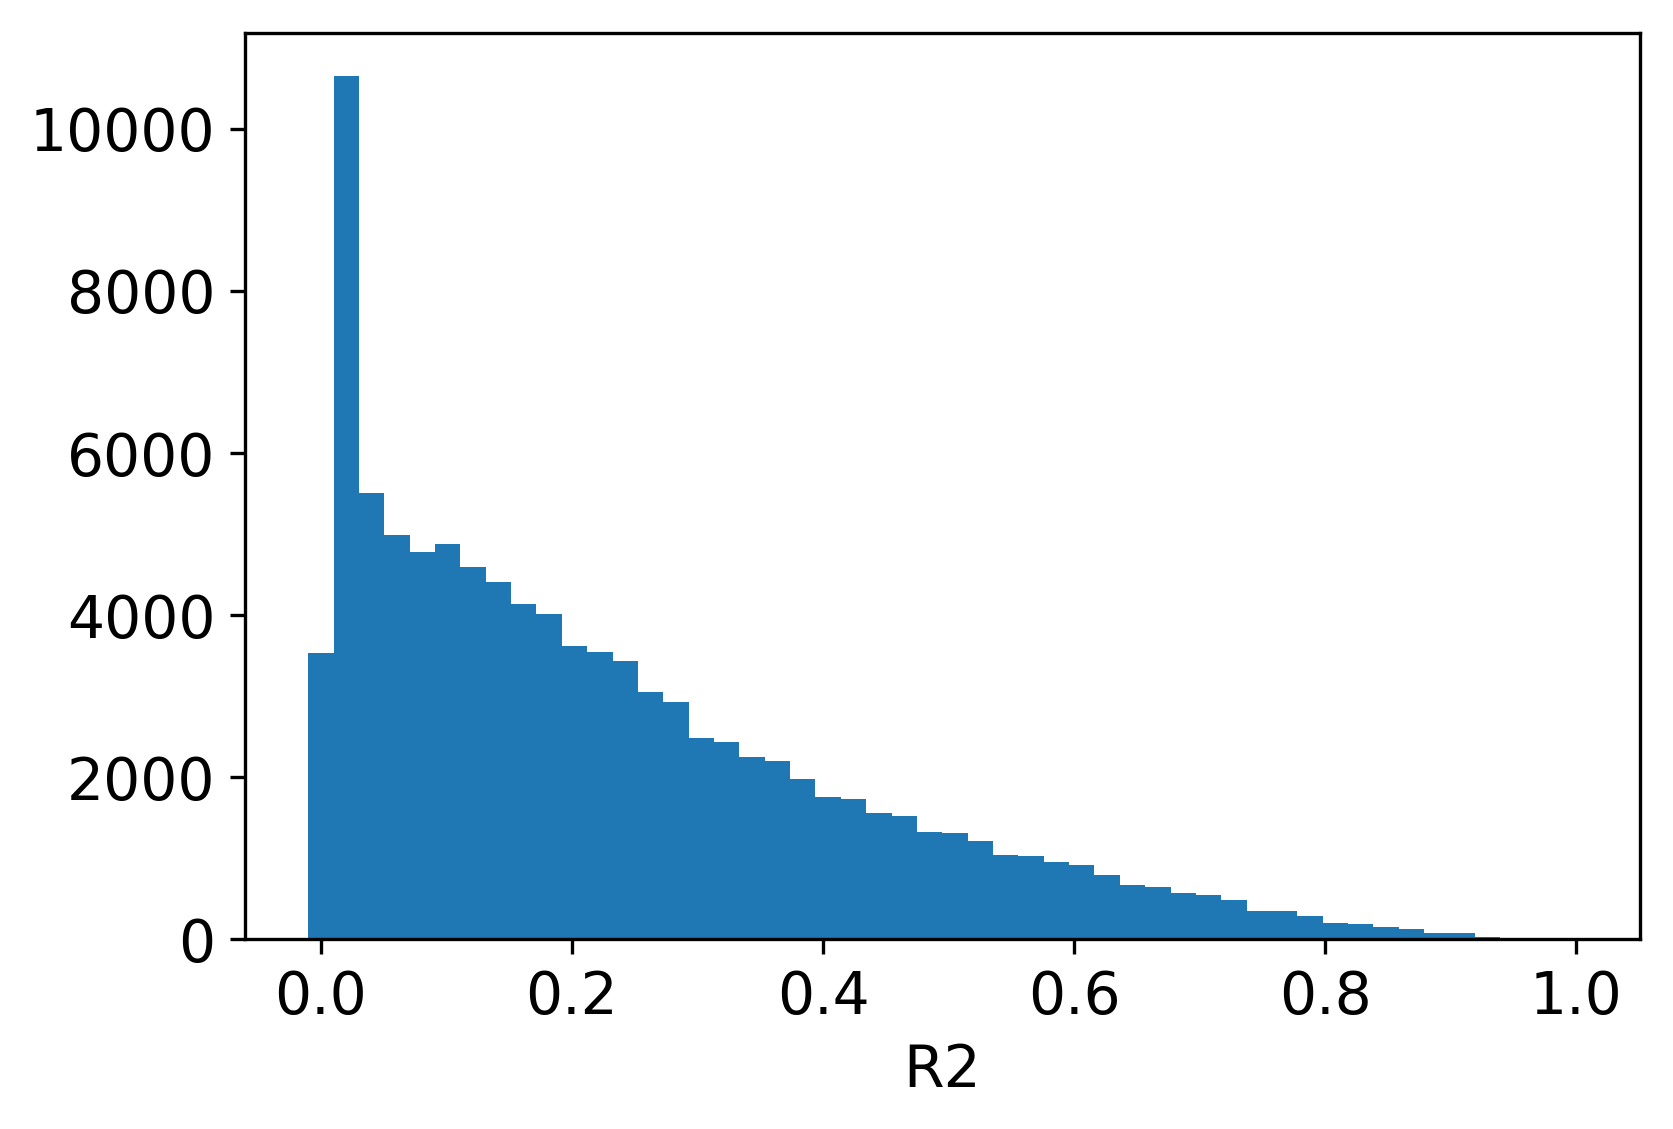

In [59]:
plt.hist(R2,range =[-0.01,1],bins = 50 )
plt.xlabel('R2')

-0.002683724335206834


Text(0.5,1,'m for individual galaxies')

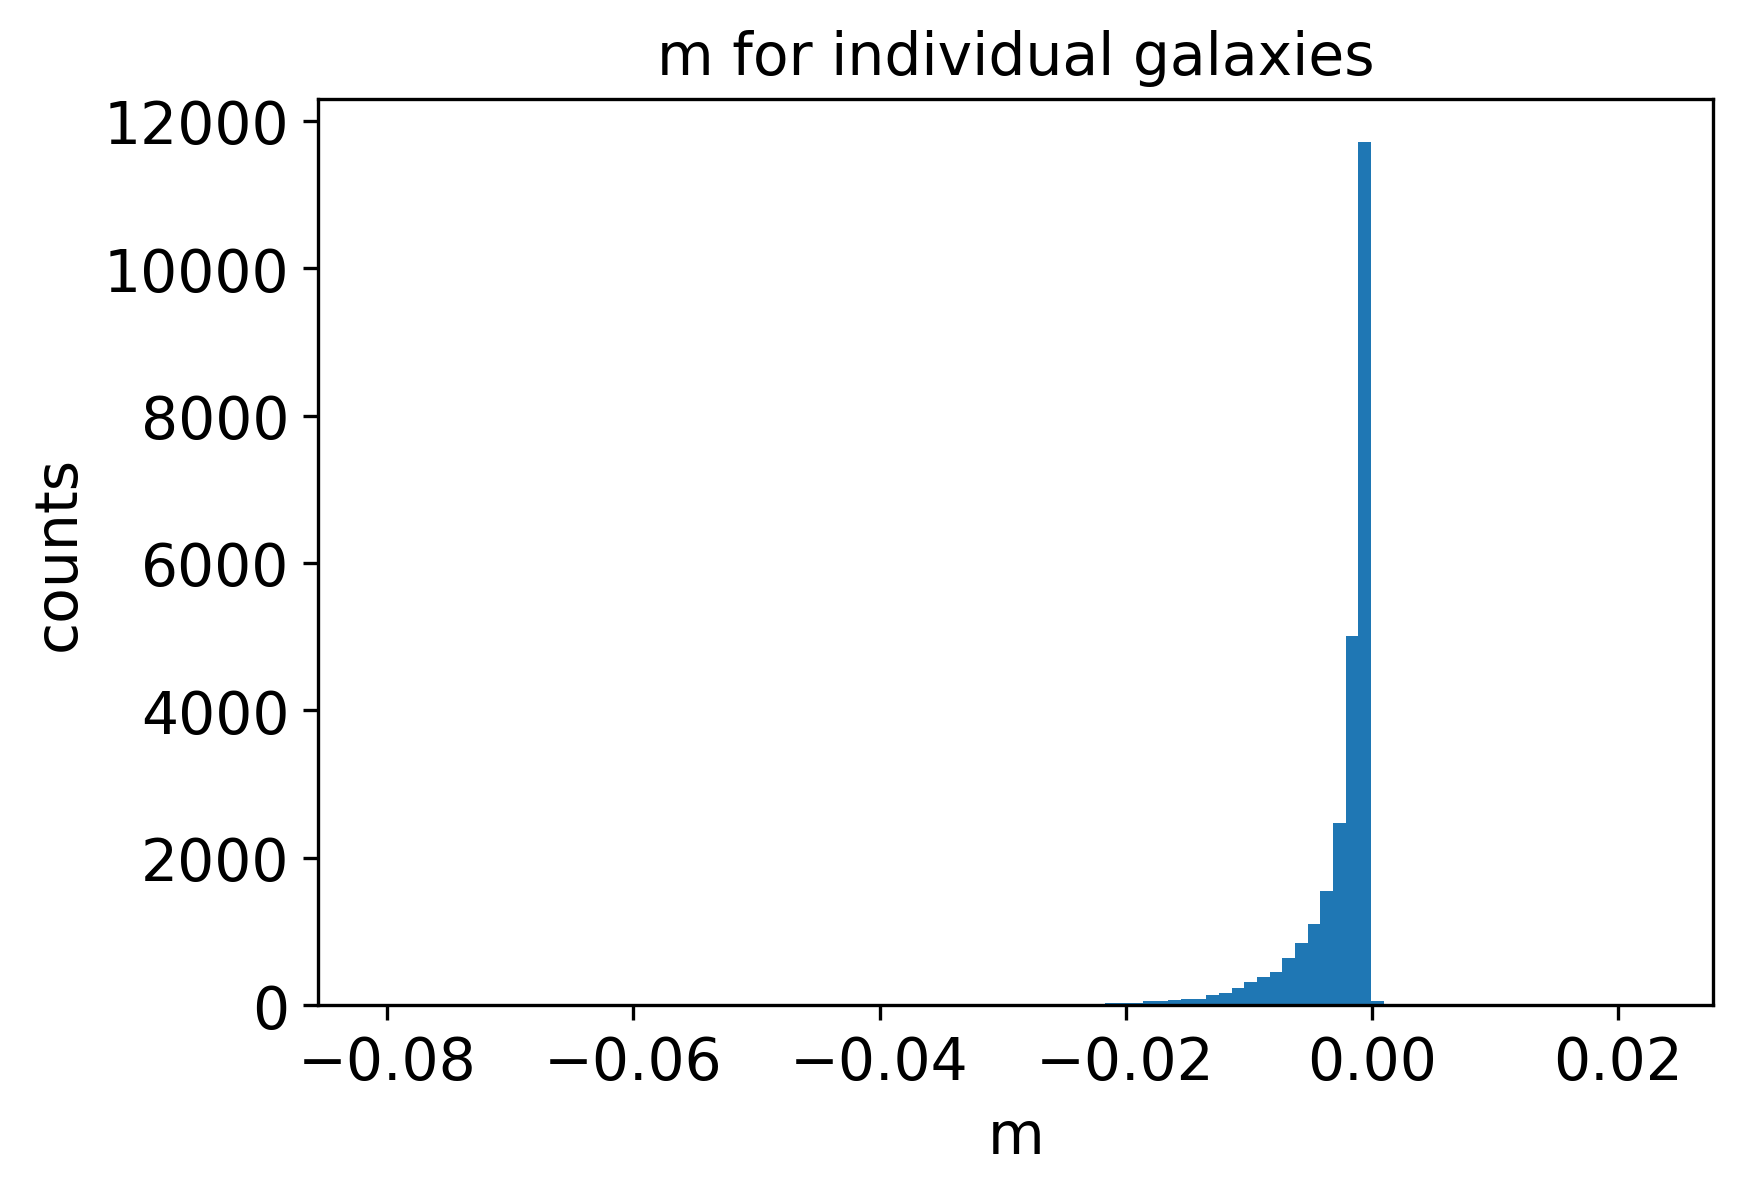

In [85]:
m1_small = m1[(m1<0.05)&(m1>-0.1)]
print np.mean(m1_small)
plt.hist(m1_small, 100)
#plt.yscale('log')
plt.xlabel('m')
plt.ylabel('counts')
plt.title('m for individual galaxies')

(-0.05, 0.01)

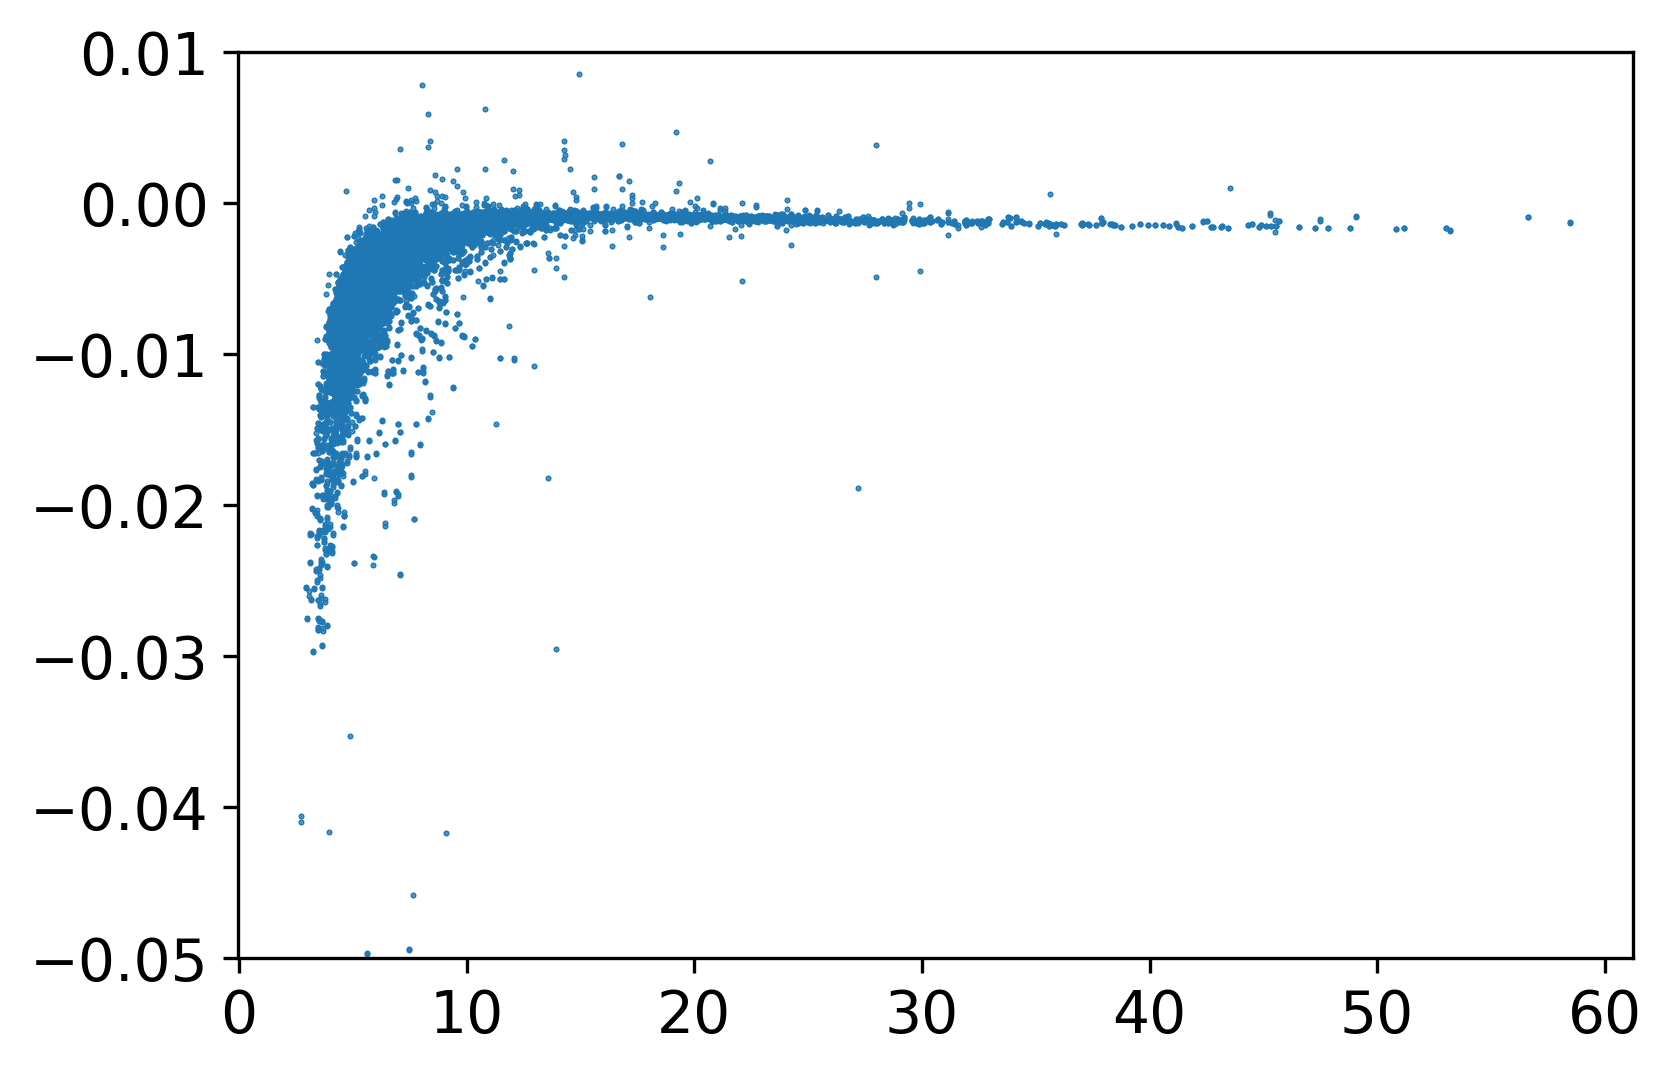

In [86]:
m1 = np.array(list(ana.df['m']))
rad = np.array(list(ana.df['flux_radius']))
plt.scatter(rad,m1,s=0.2)
plt.ylim([-0.05,0.01])

[16.65387344 21.85457802 22.69669724 23.24156761 23.65234947 23.97498131
 24.24989891 24.49571228 24.73199654 24.96195412 25.19998932]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0,0.5,'$m/ B[\\rho^{(4)}]$ ')

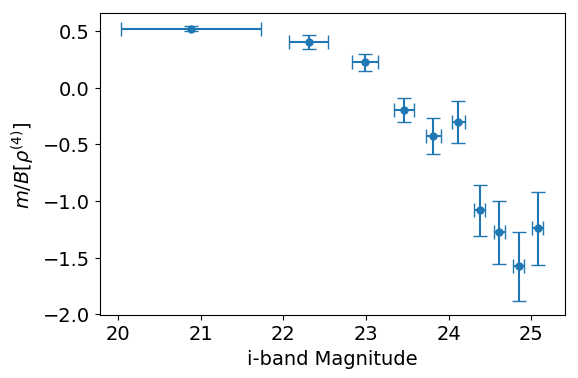

In [48]:
#Magnitute

slope, mag, slope_err, mag_err = ana.bin_by("magnitude", 10, by_num = True)
plt.errorbar(mag,slope,xerr=mag_err,yerr = slope_err ,fmt="o", markersize=5, capsize=5)
plt.xlabel("i-band Magnitude")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
#plt.ylim([-2,2])

In [96]:
with open('../notebook/Test_Results/iband_mag_bins.pkl','w') as f:
    pickle.dump([slope, mag, slope_err, mag_err],f)

In [69]:
sersic_list = ana.df['sersicn']
print(np.mean(sersic_list))

1.30370527439


In [73]:
sersic_list = ana.df['sersicn']
print(np.mean(sersic_list))

1.30280385544


[  0.29779057   7.19979582   8.29544436   9.39397992  10.55500505
  11.89218528  13.49753029  15.60211582  18.55613315  23.97064789
 112.01192815]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0, 0.5, '$m/ B[\\rho^{(4)}]$')

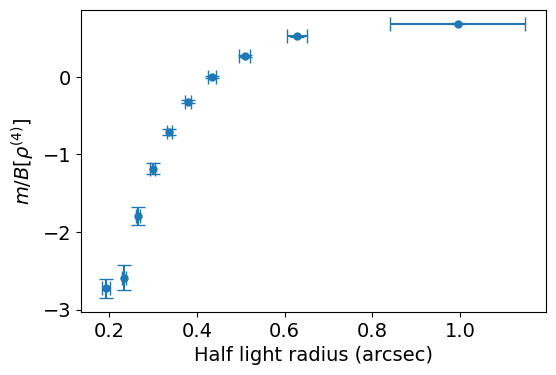

In [35]:
slope, hlr, slope_err, hlr_err = ana.bin_by("hlr" , 10 , by_num = True , bootstrap = True,)
plt.errorbar(np.array(hlr) * 0.03 ,slope,xerr = 0.5*np.array(hlr_err)*0.03, yerr =0.5*np.array(slope_err),  fmt="o", markersize=5, capsize=5)
plt.xlabel("Half light radius (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$')
#plt.ylim([-4,4])

In [89]:
with open('../notebook/Test_Results/hlr_bins_0d35.pkl','wb') as f:
    pickle.dump([slope, hlr, slope_err, hlr_err],f)

[ 4.18757105  6.44158602  7.25374651  8.06096554  8.90229893  9.83543777
 10.90890217 12.28621292 14.24209499 17.54662514 59.26419449]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0, 0.5, '$m/ B[\\rho^{(4)}]$')

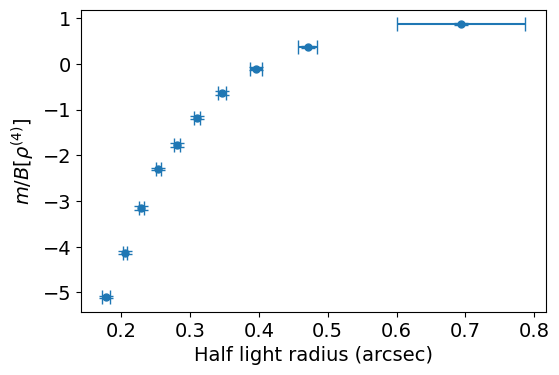

In [15]:
slope, flux_radius, slope_err, flux_radius_err = ana.bin_by("flux_radius", 10 , by_num = True,bootstrap = True,)
plt.errorbar(np.array(flux_radius) * 0.03 ,slope,xerr = 0.5*np.array(flux_radius_err)*0.03, yerr =0.5*np.array(slope_err),  fmt="o", markersize=5, capsize=5)
plt.xlabel("Half light radius (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$')
#plt.ylim([-4,4])

In [19]:
slope, size_ratio, slope_err, size_ratio_err = ana.bin_by("size_ratio", 10 , by_num = True,bootstrap = True,)


[ 0.02977906  0.71963199  0.82895639  0.93886631  1.05473935  1.1884737
  1.34849399  1.55837631  1.85473442  2.39552839 22.442375  ]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


In [21]:
size_ratio

[0.6425240865332252,
 0.7753071116911017,
 0.8831504987680754,
 0.9964017303419178,
 1.1204554811278473,
 1.266143213555797,
 1.449830616237272,
 1.6952870135115565,
 2.0897270932598837,
 3.3211553700061383]

Text(0, 0.5, '$m/ B[\\rho^{(4)}]$')

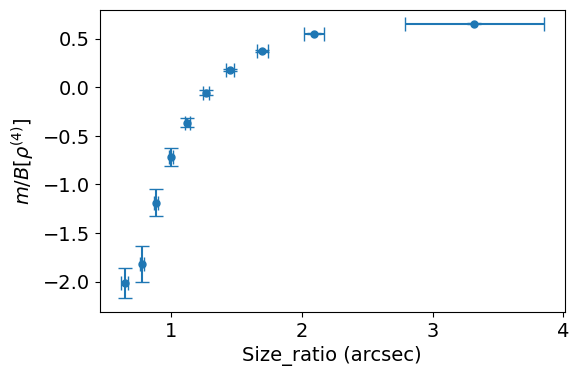

In [20]:
plt.errorbar(np.array(size_ratio)  ,slope , xerr = 0.5*np.array(size_ratio_err), yerr = 0.5*np.array(slope_err),  fmt="o", markersize=5, capsize=5)
plt.xlabel("Size_ratio (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$')
#plt.ylim([-4,4])

In [100]:
with open('../notebook/Test_Results/flux_radius_bins_0d35.pkl','w') as f:
    pickle.dump([slope, flux_radius, slope_err, flux_radius_err],f)

[0.1        0.4733743  0.67346262 0.87246726 1.12645104 4.39118618]
bin  0
bin  1
bin  2
bin  3
bin  4


Text(0,0.5,'shear bias/kurtosis bias')

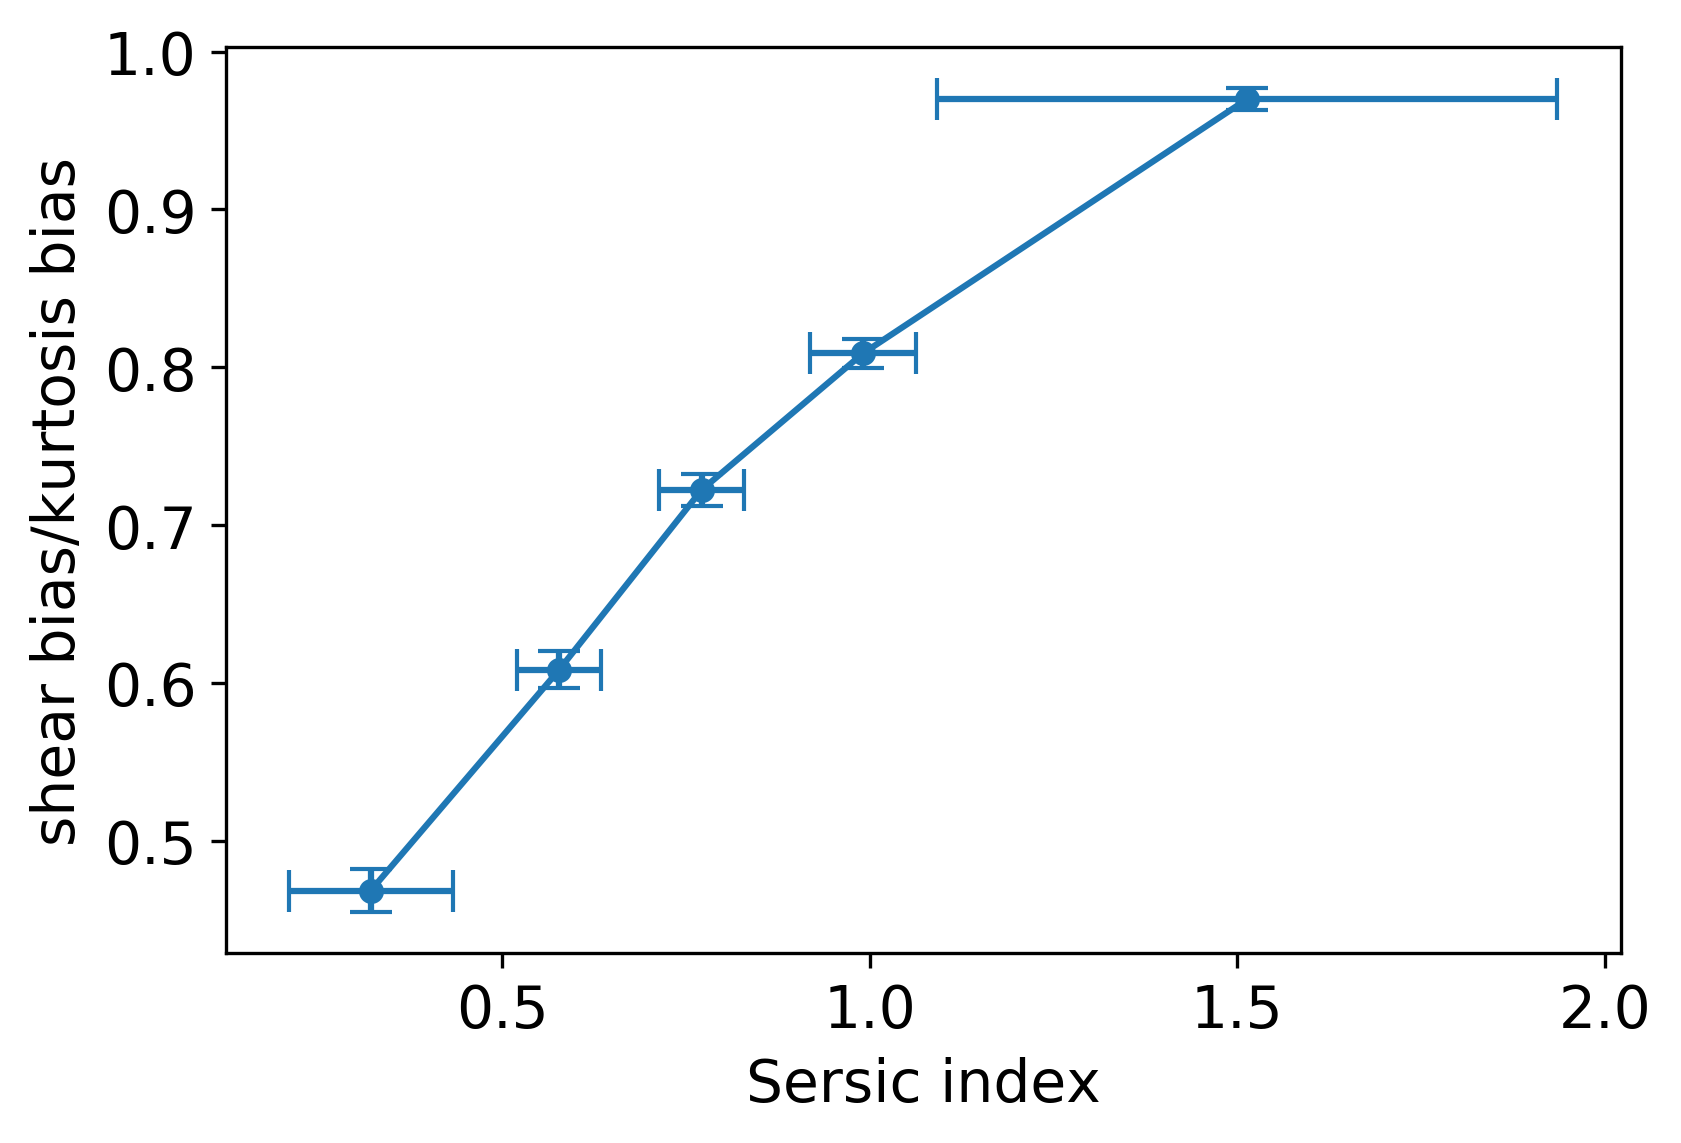

In [63]:
slope, sersicn, slope_err, sersicn_error = ana.bin_by("sersicn", 5 ,by_num = True)
plt.errorbar(sersicn ,slope,xerr = np.array(sersicn_error), yerr =slope_err,  fmt="o-", markersize=5, capsize=5)
plt.xlabel("Sersic index")
plt.ylabel("shear bias/kurtosis bias")
# plt.xlim([0,50])
#plt.ylim([-4,4])

[0.14739101 0.29696383 0.35670814 0.41278718 0.46931909 0.53166332
 0.59581656 0.65946544 0.73656167 0.82069022 0.99782545]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0,0.5,'shear bias/kurtosis bias')

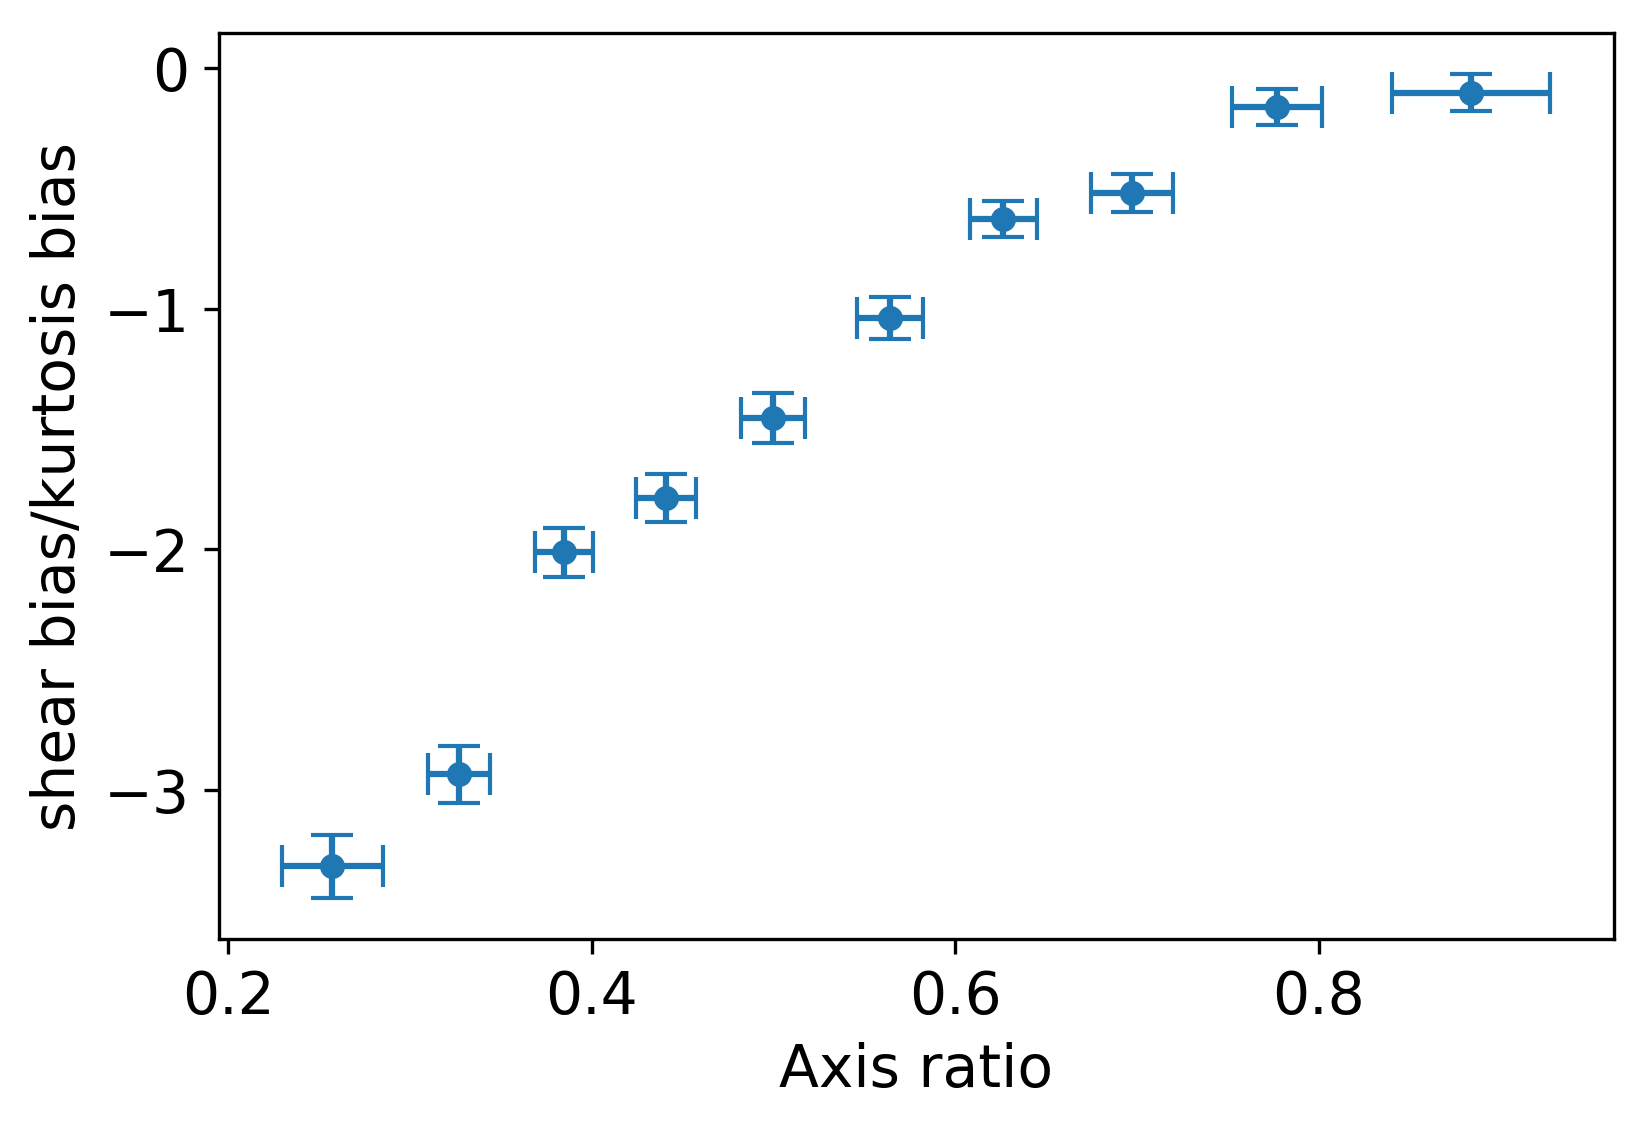

In [90]:
#q

slope, q, slope_err, q_err = ana.bin_by("q", 10, by_num = True)
plt.errorbar(q,slope,xerr=q_err,yerr = slope_err ,fmt="o", markersize=5, capsize=5)
plt.xlabel("Axis ratio")
plt.ylabel("shear bias/kurtosis bias")
#plt.ylim([-2,2])

[4.99999989e-03 3.11399996e-01 4.37700003e-01 6.06199980e-01
 7.35300004e-01 8.57699990e-01 9.83399987e-01 1.16700006e+00
 1.40289998e+00 1.94159997e+00 5.40840006e+00]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0, 0.5, '$m/ B[\\rho^{(4)}]$ ')

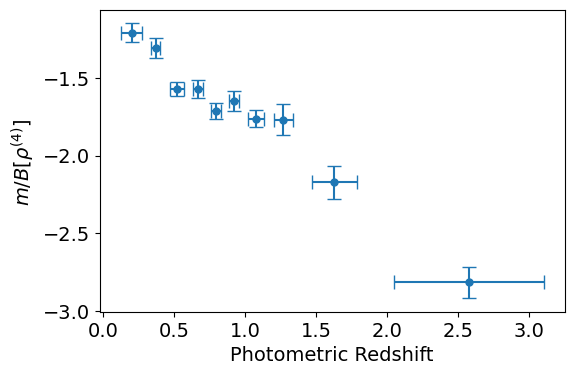

In [42]:

slope, redshift, slope_err, redshift_err = ana.bin_by("zphot", 10, by_num = True)
plt.errorbar(redshift,slope,xerr=redshift_err,yerr = slope_err ,fmt="o", markersize=5, capsize=5)
plt.xlabel("Photometric Redshift")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
#plt.ylim([-2,2])

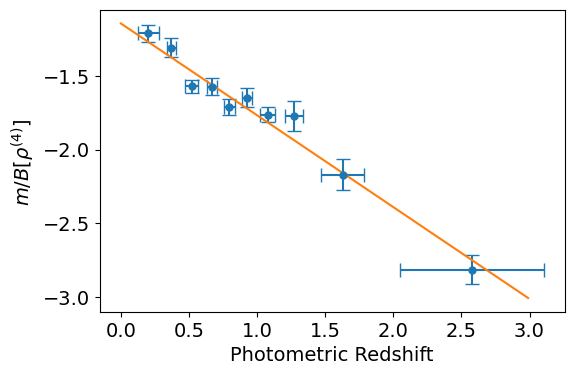

In [46]:
plt.errorbar(redshift,slope,xerr=redshift_err,yerr = slope_err ,fmt="o", markersize=5, capsize=5)
plt.xlabel("Photometric Redshift")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
plt.plot(redshift_linear, slope_linear)

In [44]:
def linear(x,m0,c):
    #return m0*x
    return m0*(2*x - 2.5)/2.5 + c

import scipy.optimize

params, cov =  curve_fit(linear, redshift, slope, sigma = slope_err)




In [33]:
print(params)
print(cov)
print(np.sqrt(cov[0][0]))

[-0.45959689 -0.50554472]
[[0.00257134 0.00103936]
 [0.00103936 0.00090564]]
0.05070834765376639


In [23]:
linear(0,-0.36159485, -0.2319)

0.12969485000000003

In [51]:
linear(2.4,-0.36159485, -0.2319)

-0.59349485

In [53]:
-0.59349485 - 0.1296948

-0.72318965

In [54]:
np.sqrt(0.04)

0.2

In [40]:
print(params,np.sqrt(cov))

(array([-0.36159485, -0.23190507]), array([[0.04187309, 0.0261524 ],
       [0.0261524 , 0.02487424]]))


In [29]:
linear(2.6, -0.4854)

-0.4854

In [30]:
-1.459 + 1.262

-0.19700000000000006

In [25]:
-0.77920254*0.0011

-0.0008571227940000001

In [55]:
0.36*0.0011

0.00039600000000000003

In [45]:
redshift_linear = np.arange(0,3.0,0.01)
slope_linear = linear(redshift_linear, *params)

In [107]:
print params

[-0.48538846]


In [47]:
with open('../notebook/Test_Results/redshift_bins_mof.pkl','wb') as f:
    pickle.dump([slope, redshift, slope_err, redshift_err, redshift_linear,slope_linear],f)

In [ ]:
slope_unidistance, zphot_unidistance, slope_err_unidistance, zphot_err_unidistance = ana.bin_by("zphot", 10 ,by_num = False)
slope_unisize, zphot_unisize, slope_err_unisize, zphot_err_unisize = ana.bin_by("zphot", 10 ,by_num = True)



In [65]:
f_unidistance = interpolate.interp1d(zphot_unidistance, slope_unidistance, kind = 'quadratic',fill_value = 'extrapolate')
f_unisize = interpolate.interp1d(zphot_unisize, slope_unisize, kind = 'quadratic',fill_value = 'extrapolate')

redshift_range_unidistance = np.arange(0.1,4.9, 0.01)
predict_unidistance = f_unidistance(redshift_range_unidistance)
redshift_range_unisize = np.arange(0.1, 2.65, 0.01)
predict_unisize = f_unisize(redshift_range_unisize)

Text(0,0.5,'$m/ B[\\rho^{(4)}]$ ')

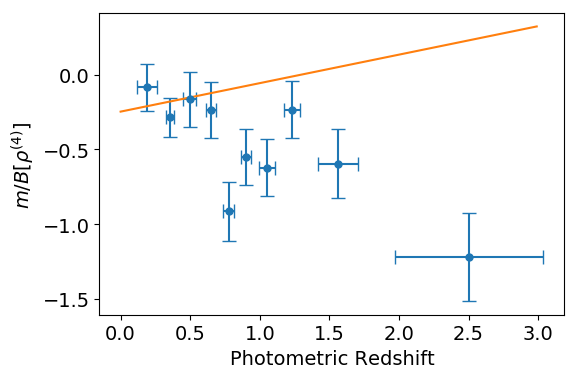

In [104]:
plt.errorbar(redshift,slope,xerr=redshift_err,yerr = slope_err ,fmt="o", markersize=5, capsize=5)
plt.plot(redshift_linear,slope_linear)


plt.xlabel("Photometric Redshift")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')

In [24]:
print zphot_unisize
print slope_unisize

[0.19733751026398771, 0.3672068836659205, 0.5194173771110507, 0.6730848061791219, 0.8019621886842894, 0.9315866639891291, 1.0955902707312377, 1.294214468981753, 1.680838019027856, 2.649548520058027]
[-0.8679968798160462, -0.9468279960520093, -1.2565173164681194, -1.1575164641167353, -1.4077293434181184, -1.3027700617539977, -1.5512877050265168, -1.5594427178914292, -2.63747530253512, -3.4805186677337163]


Text(0,0.5,'shear bias/kurtosis bias')

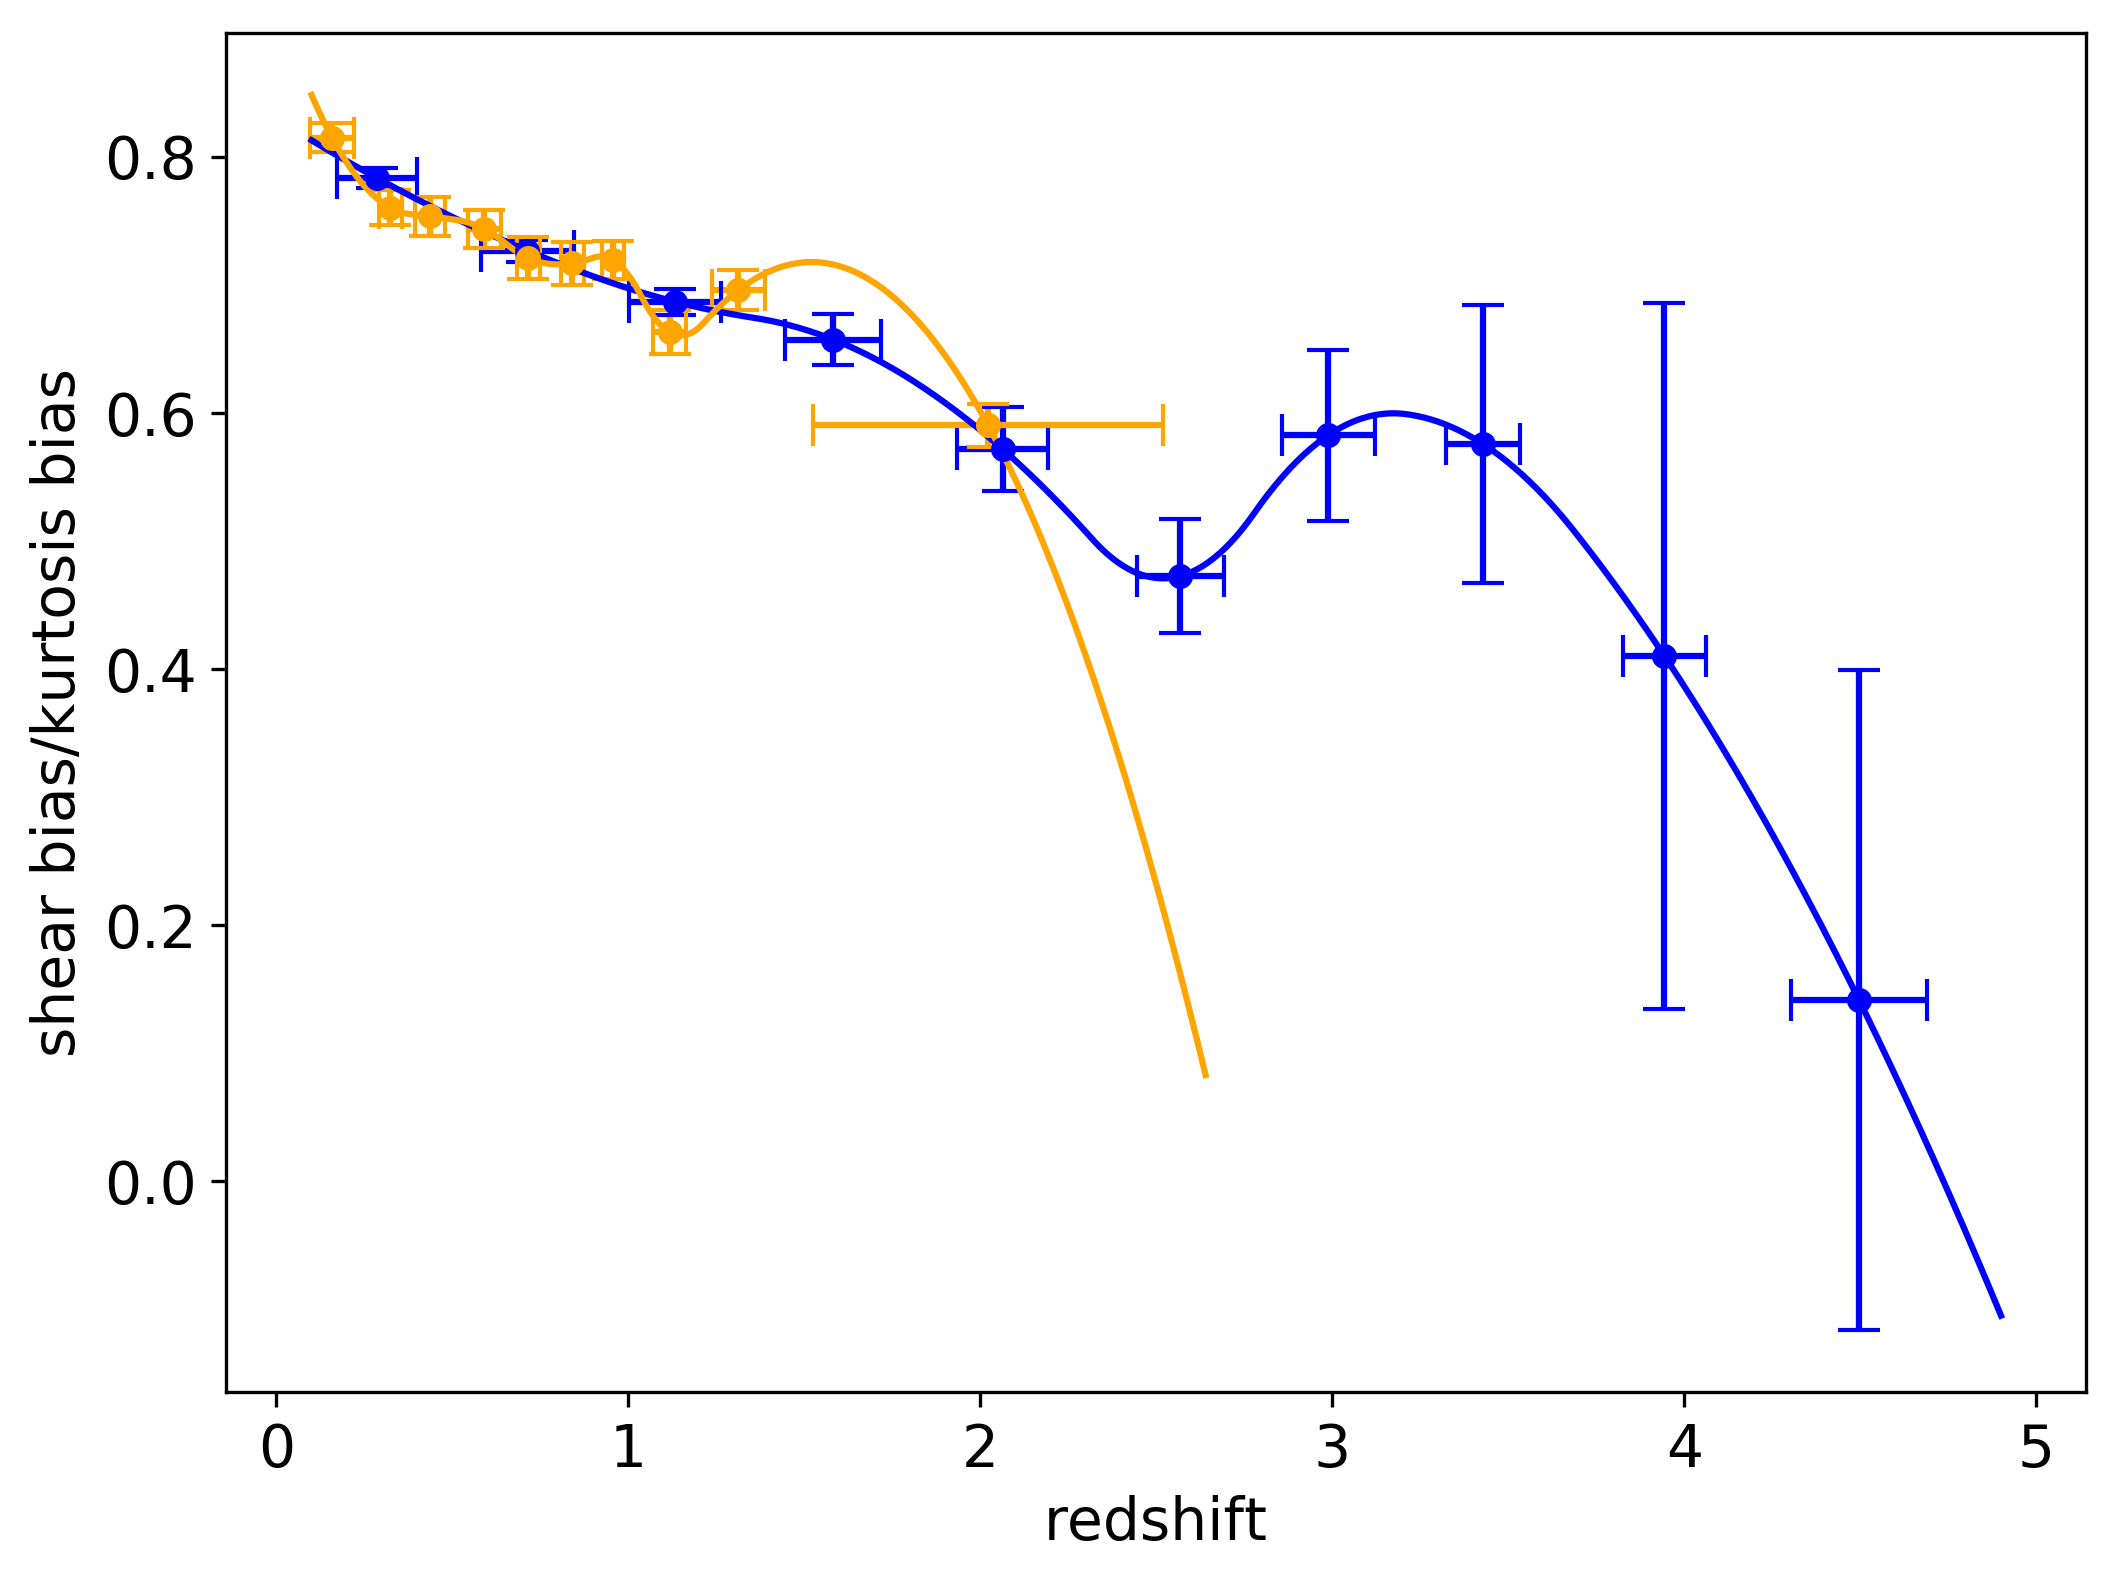

In [66]:
plt.figure(figsize = (8,6))
plt.errorbar(zphot_unidistance,slope_unidistance,xerr = zphot_err_unidistance, yerr =slope_err_unidistance,  fmt="o", markersize=5, capsize=5, color = 'blue')
plt.errorbar(zphot_unisize,slope_unisize,xerr = zphot_err_unisize, yerr =slope_err_unisize,  fmt="o", markersize=5, capsize=5, color = 'orange')
plt.plot(redshift_range_unidistance,predict_unidistance, color = 'blue'  )
plt.plot(redshift_range_unisize,predict_unisize ,color = 'orange')
plt.xlabel("redshift")
plt.ylabel("shear bias/kurtosis bias")
#plt.ylim([-5,0])
#plt.xlim(0,4)

In [100]:
def polyx(x, coeff, power):
    output = np.zeros(x.shape)
    for i in range(power,-1,-1):
        output+=coeff[i]*x**(power-i)
        
    return output
        
        

In [101]:
def AIC(y,y_pred,sigma, k):
    resid = y - y_pred
    #print resid**2,np.array(sigma)**2
    sse = np.mean( - (resid ** 2) / (2*np.array(sigma)**2))
    #print sse
    L = np.sum(np.log(1/(np.sqrt(2*np.pi)*np.array(sigma)))) + sse
    #print - resid ** 2 / 2*np.array(sigma)**2
    return 2*k  - 2*sse

In [27]:
AIC_unidistance = []
AIC_unisize = []

for i in range(1,10):
    
    coeff_unidistance = np.polyfit(zphot_unidistance, slope_unidistance, i)
    redshift_range_unidistance = np.arange(0.1,4.9, 0.01)
    predict_unidistance = polyx(redshift_range_unidistance,coeff_unidistance,i)
    data_predict_unidistance = polyx(np.array(zphot_unidistance),coeff_unidistance,i )
    AIC_unidistance.append(AIC(slope_unidistance,data_predict_unidistance,slope_err_unidistance,len(coeff_unidistance)))
    
    coeff_unisize = np.polyfit(zphot_unisize, slope_unisize, i)
    redshift_range_unisize = np.arange(0.1, 3.0, 0.01)
    predict_unisize = polyx(redshift_range_unisize,coeff_unisize,i)
    data_predict_unisize = polyx(np.array(zphot_unisize),coeff_unisize,i )
    AIC_unisize.append(AIC(slope_unisize,data_predict_unisize,slope_err_unisize,len(coeff_unisize)))

np.save('redshift_coeff_shear2.npy', coeff_unidistance )

Text(0,0.5,'AIC')

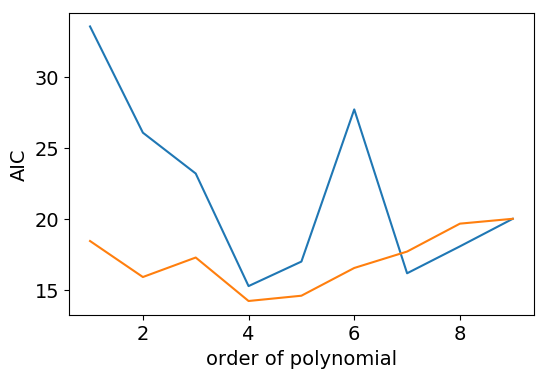

In [13]:
plt.figure(dpi = 100)
n = list(range(1,10))
plt.plot(n,AIC_unidistance)
plt.plot(n,AIC_unisize)
#print AIC_unidistance
plt.xlabel('order of polynomial')
plt.ylabel('AIC')

In [102]:
coeff_unidistance = np.polyfit(zphot_unidistance, slope_unidistance, 4)
redshift_range_unidistance = np.arange(0.1,4.9, 0.01)
predict_unidistance = polyx(redshift_range_unidistance,coeff_unidistance,4)

coeff_unisize = np.polyfit(zphot_unisize, slope_unisize, 4)
redshift_range_unisize = np.arange(0.1, 3.0, 0.01)
predict_unisize = polyx(redshift_range_unisize,coeff_unisize,4)


In [111]:
with open('../notebook/Test_Results/redshift_bins_fitting.pkl','w') as f:
    pickle.dump([zphot_unidistance, slope_unidistance, zphot_err_unidistance, slope_err_unidistance,redshift_range_unidistance,predict_unidistance],f)

NameError: name 'zphot_unidistance' is not defined

Text(0,0.5,'$m(z)/ B[\\rho^{(4)}]$ ')

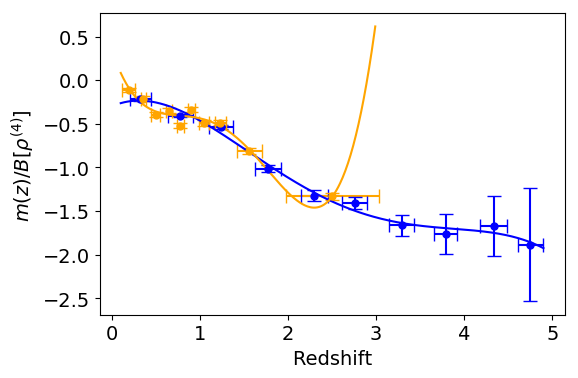

In [109]:
#plt.figure(figsize = (6,4))
plt.errorbar(zphot_unidistance,slope_unidistance,xerr = zphot_err_unidistance, yerr =slope_err_unidistance,  fmt="o", markersize=5, capsize=5, color = 'blue',label = 'equal redshift bins')
plt.errorbar(zphot_unisize,slope_unisize,xerr = zphot_err_unisize, yerr =slope_err_unisize,  fmt="o", markersize=5, capsize=5, color = 'orange', label = 'equal number bins')
plt.plot(redshift_range_unidistance,predict_unidistance, color = 'blue'  )
plt.plot(redshift_range_unisize,predict_unisize ,color = 'orange')
plt.xlabel("Redshift")
plt.ylabel(r'$m(z)/ B[\rho^{(4)}]$ ')
#plt.ylim([-4,0])
#plt.xlim(0,3.5)
#plt.legend()

In [14]:
bin_bound = [4.99999989e-03, 3.08499992e-01, 4.30500001e-01, 6.04600012e-01,
 7.39300013e-01, 8.65300000e-01, 9.94199991e-01, 1.18089998e+00,
 1.43540001e+00, 1.98199999e+00, 5.19740009e+00]
print slope



[-0.9337193897359375, -1.3290712683143286, -1.6249972376959099, -2.9107759554032935, -3.3586809006957052, -3.4956154881973167, -3.467421632569139, -5.8041679713765175, -6.190717322386214, -10.153575494556614]


In [14]:
bin_bound = [4.99999989e-03, 3.08499992e-01, 4.30500001e-01, 6.04600012e-01,
 7.39300013e-01, 8.65300000e-01, 9.94199991e-01, 1.18089998e+00,
 1.43540001e+00, 1.98199999e+00, 5.19740009e+00]
print slope



[-0.9337193897359375, -1.3290712683143286, -1.6249972376959099, -2.9107759554032935, -3.3586809006957052, -3.4956154881973167, -3.467421632569139, -5.8041679713765175, -6.190717322386214, -10.153575494556614]


In [12]:
def slope_from_redshift(z,bin_bound,slope):
    
    if z<bin_bound[0] or z>bin_bound[-1]:
        print "z out of range"
        return None
    
    for i in range(len(slope)):
        if z>=bin_bound[i] and z<=bin_bound[i+1]:
            return slope[i]
    

In [29]:
slope_from_redshift(3, bin_bound, slope)

-3.4528107492349864

In [92]:
print np.mean(np.array(list(ana.df['sersicn'])))

1.3446066859647605


In [94]:

low_test = [("sersic" ,1.0    ,0.0,0.28,0.01,0.0,"kolmogorov"  ,0.4+0.1*i   ,0.0,0.0,{'subtract_intersection':True,'mod_kol_radius_ratio':1.1,'sersicn':0.5,'metacal_method':'estimateShear'}) for i in range(20)
  ]
low_result = do_tests(low_test)

mid_test = [("sersic" ,1.0    ,0.0,0.28,0.01,0.0,"kolmogorov"  ,0.4+0.2*i     ,0.0,0.0,{'subtract_intersection':True,'mod_kol_radius_ratio':1.1,'sersicn':1.8,'metacal_method':'estimateShear'}) for i in range(20)
  ]
mid_result = do_tests(mid_test)

high_test = [("sersic" ,1.0    ,0.0,0.28,0.01,0.0,"kolmogorov"  ,0.4+0.4*i     ,0.0,0.0,{'subtract_intersection':True,'mod_kol_radius_ratio':1.1,'sersicn':3.5,'metacal_method':'estimateShear'}) for i in range(20)
  ]
high_result = do_tests(high_test)


In [22]:
slope, radius, slope_err, radius_err = ana.bin_by("flux_radius", 10 , by_num = True,bootstrap = True)


[ 4.61805582  6.6062274   7.44348574  8.26109123  9.10657501 10.02585602
 11.12371349 12.50026703 14.4610672  17.82880211 58.67473221]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


(-6, 2.5)

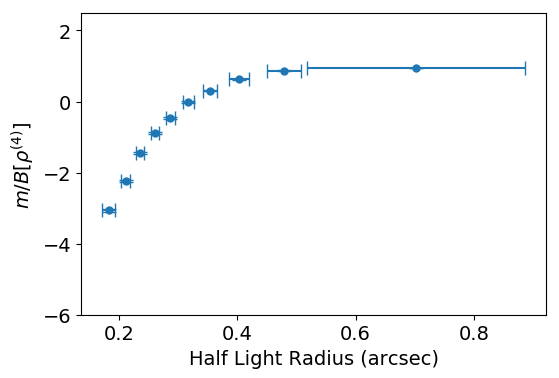

In [23]:
plt.errorbar(np.array(radius)*0.03 ,slope,xerr = np.array(radius_err)*0.03, yerr =slope_err,  fmt="o", markersize=5, capsize=5)
#plt.plot([t['gal_sigma']/t['psf_sigma']*0.3 for t in this_result],np.array([t["shear_bias"]/((t['kurtosis_perc_error'])) for t in this_result]),label='sersic index for galaxy is'+str(this_result[0]['sersicn']))

plt.xlabel("Half Light Radius (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
plt.ylim([-6,2.5])
#plt.title("10k galaxies, kolmogorov PSF 0.3 arcsec , pixel scale = 0.2 arcsec")
#plt.ylim([-4,4])

In [98]:
lowsi = ana.df[(ana.df['sersicn']<1.0) & (ana.df['sersicn']>0.1)]
midsi = ana.df[(ana.df['sersicn']<3.0) & (ana.df['sersicn']>1.0)]
highsi = ana.df[(ana.df['sersicn']>=3.0) & (ana.df['sersicn']<5.0)]



slopelow, radiuslow, slope_errlow, radius_errlow = ana.bin_by("hlr", 10 , by_num = True,bootstrap = True,df = lowsi)
slopemid, radiusmid, slope_errmid, radius_errmid = ana.bin_by("hlr", 10 , by_num = True,bootstrap = True,df = midsi)

slopehigh, radiushigh, slope_errhigh, radius_errhigh = ana.bin_by("hlr", 10 , by_num = True,bootstrap = True,df = highsi)


[ 5.16800832  7.55633695  8.51001412  9.4535488  10.47329083 11.58615422
 12.94209334 14.6318849  16.91941791 20.92460473 79.75586167]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9
[ 4.25245612  6.79114006  7.9922017   9.22357021 10.56958742 12.18530545
 14.07869226 16.54037684 20.09532378 26.13474422 95.7885264 ]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9
[  4.43113144   6.42790514   7.74673748   9.35948472  10.88907425
  13.03206868  15.79358949  19.57599237  25.2444881   35.17513317
 157.16973997]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


In [94]:
print highsi.shape

(5682, 23)


In [99]:
with open('../notebook/Test_Results/sersic3class_bins1.pkl','wb') as f:
    pickle.dump([slopelow, radiuslow, slope_errlow, radius_errlow, slopemid, radiusmid, slope_errmid, radius_errmid,slopehigh, radiushigh, slope_errhigh, radius_errhigh  ],f)
    
    
    
    
    

(-6.0, 2.5)

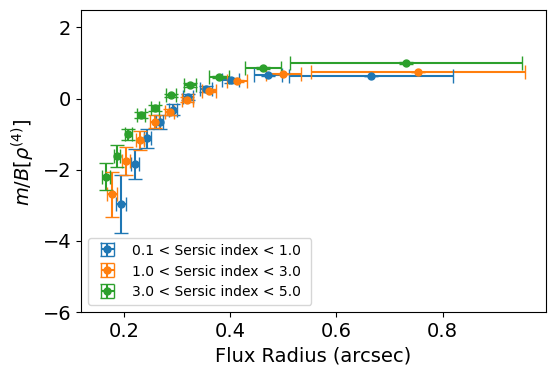

In [20]:
plt.errorbar(np.array(radiuslow)*0.03 ,slopelow,xerr = np.array(radius_errlow)*0.03, yerr =slope_errlow,  fmt="o", markersize=5, capsize=5, label = '0.1 < Sersic index < 1.0 ' )
plt.errorbar(np.array(radiusmid)*0.03 ,slopemid,xerr = np.array(radius_errmid)*0.03, yerr =slope_errmid,  fmt="o", markersize=5, capsize=5, label = '1.0 < Sersic index < 3.0 ')

plt.errorbar(np.array(radiushigh)*0.03 ,slopehigh,xerr = np.array(radius_errhigh)*0.03, yerr =slope_errhigh,  fmt="o", markersize=5, capsize=5, label = '3.0 < Sersic index < 5.0 ')

plt.xlabel("Flux Radius (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
#plt.title("10k galaxies, kolmogorov PSF 0.3 arcsec , pixel scale = 0.2 arcsec")
plt.legend()
plt.ylim([-6,2.5])

In [48]:
lowsi = ana.df[(ana.df['sersicn']<1.0) & (ana.df['sersicn']>0.1)]
midsi = ana.df[(ana.df['sersicn']<3.0) & (ana.df['sersicn']>1.0)]
highsi = ana.df[(ana.df['sersicn']>=3.0) & (ana.df['sersicn']<5.0)]



slopelow, ratiolow, slope_errlow, ratio_errlow = ana.bin_by("size_ratio", 10 , by_num = True,bootstrap = True,df = lowsi)
slopemid, ratiomid, slope_errmid, ratio_errmid = ana.bin_by("size_ratio", 10 , by_num = True,bootstrap = True,df = midsi)

slopehigh, ratiohigh, slope_errhigh, ratio_errhigh = ana.bin_by("size_ratio", 10 , by_num = True,bootstrap = True,df = highsi)


[0.49965572 0.69890103 0.77987781 0.85615892 0.93708057 1.0249279
 1.12844629 1.26014919 1.44475861 1.75013924 5.86747322]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9
[0.47600875 0.6295938  0.70714226 0.78881712 0.87984676 0.98097305
 1.09708891 1.24417906 1.45587206 1.81487103 5.8109581 ]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9
[0.44990797 0.58502989 0.65301681 0.72248111 0.8054575  0.89493685
 1.00402441 1.13108883 1.32608843 1.67336979 5.92641945]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


(-6.0, 2.5)

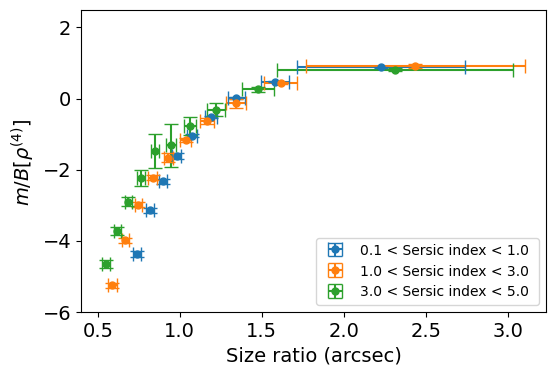

In [49]:
plt.errorbar(np.array(ratiolow) ,slopelow,xerr = np.array(ratio_errlow), yerr =slope_errlow,  fmt="o", markersize=5, capsize=5, label = '0.1 < Sersic index < 1.0 ' )
plt.errorbar(np.array(ratiomid),slopemid,xerr = np.array(ratio_errmid), yerr =slope_errmid,  fmt="o", markersize=5, capsize=5, label = '1.0 < Sersic index < 3.0 ')

plt.errorbar(np.array(ratiohigh),slopehigh,xerr = np.array(ratio_errhigh), yerr =slope_errhigh,  fmt="o", markersize=5, capsize=5, label = '3.0 < Sersic index < 5.0 ')

plt.xlabel("Size ratio (arcsec)")
plt.ylabel(r'$m/ B[\rho^{(4)}]$ ')
#plt.title("10k galaxies, kolmogorov PSF 0.3 arcsec , pixel scale = 0.2 arcsec")
plt.legend()
plt.ylim([-6,2.5])

In [ ]:
namelist = ['kol1d02','kol1d04','kol1d06','kol1d08','kol1d1','kol1d12','kol1d14','kol1d16']
kurtosis_list = []
bias_list = []
bias_std_list = []
for i in range(len(namelist)):
    name = namelist[i]
    filename = "Outputs252/"+name+"/"+name+"shear0d01.pkl"
    this_df = pd.read_pickle(filename)
    this_ana = analysis(dir_cat+cat_file_name, dir_cat+catparam_file_name, this_df)
    this_ana.add_everything_to_df()
    this_ana.calc_individual_shape()
    
    kurtosis_bias = this_ana.get_perc_kurtosis_bias(this_ana.df)
    kurtosis_list.append(kurtosis_bias)
    
    shear_bias, shear_bias_std = this_ana.get_shear_perc_bias(this_ana.df)
    print shear_bias, shear_bias_std
    bias_list.append(shear_bias)
    bias_std_list.append(shear_bias_std)
    


In [92]:
poly = np.polyfit(kurtosis_list,bias_list,1)
xfit = np.linspace(-0.01,0.4,100)
yfit = poly[0]*xfit+poly[1] 

In [93]:
kurtosis_list = np.array(kurtosis_list)
bias_list = np.array(bias_list)
bias_std_list = np.array(bias_std_list)

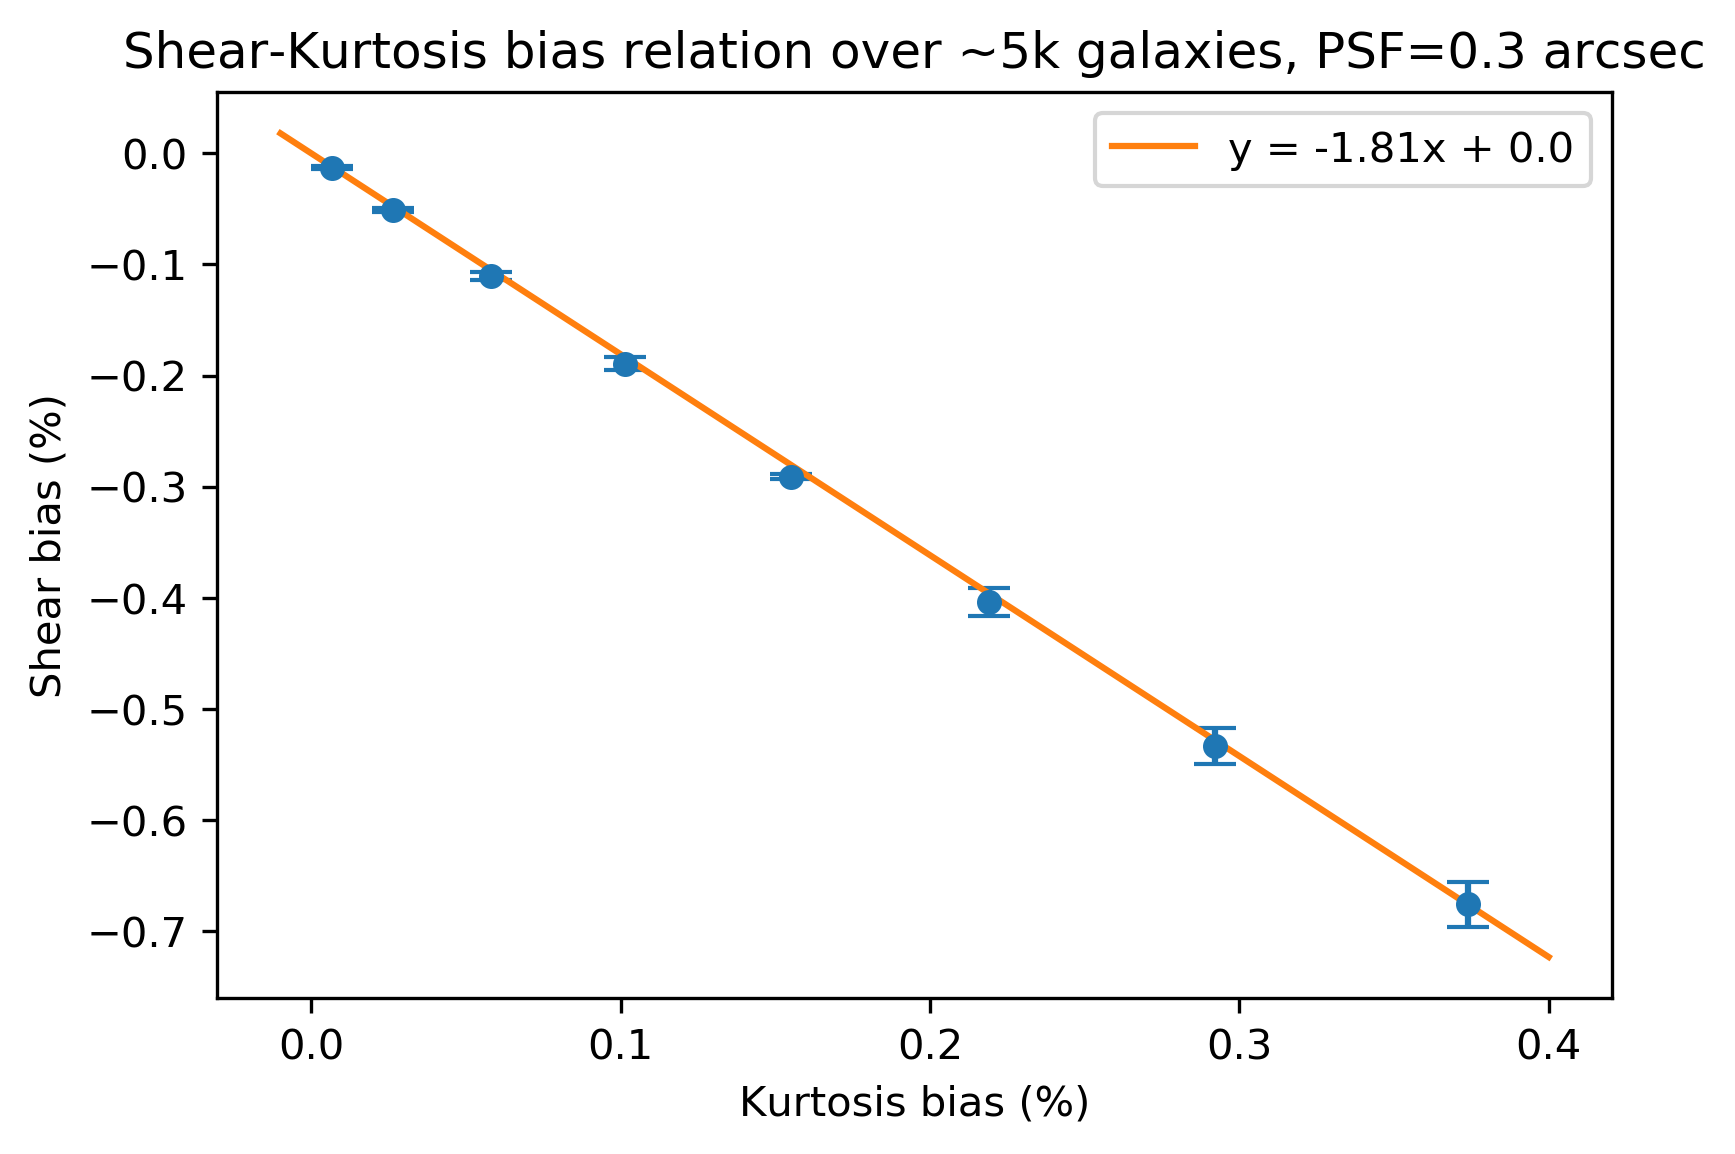

In [101]:
plt.errorbar(kurtosis_list*100, bias_list*100, bias_std_list*100,fmt='o',markersize=5, capsize=5)
plt.plot(xfit, yfit,label='y = '+str(round(poly[0],2))+"x + " + str(-round(poly[1],2)))
plt.xlabel("Kurtosis bias (%)")
plt.ylabel("Shear bias (%)")
plt.title("Shear-Kurtosis bias relation over ~5k galaxies, PSF=0.3 arcsec")
plt.legend()
plt.show()

In [31]:
def binning_plot(x,y,num,x_varname,y_varname):
    #bin by x value
    N = len(x)
    if len(x)!=len(y):
        print ("lengths of x and y are different")
        return
    bin_len = N//num
    x_arg = np.argsort(x)
    x_sort = np.sort(x)
    y_sort = y[x_arg]
    x_bin = []
    x_bin_error = []
    y_bin = []
    y_bin_error = []
    for i in range(num):
        x_sub = x_sort[i*bin_len:(i+1)*bin_len]
        y_sub = y_sort[i*bin_len:(i+1)*bin_len]
        x_bin.append(np.mean(x_sub))
        y_bin.append(np.mean(y_sub))
        x_bin_error.append(np.std(x_sub))
        y_bin_error.append(np.std(y_sub))
        
    plt.errorbar(x_bin, y_bin, xerr = x_bin_error, yerr = y_bin_error, fmt = 'o-',markersize=5, capsize=5)
    plt.xlabel(x_varname)
    plt.ylabel(y_varname)
    plt.show()
    return 0   
    #return np.array(x_bin), np.array(y_bin), np.array(x_bin_error), np.array(y_bin_error)
    

In [32]:
#look at distribution of properties:

photz_list = np.array(ana.df['zphot'])
radius_list = np.array(ana.df['flux_radius'])
hlr_list = np.array(ana.df['hlr'])
sersicn_list = np.array(ana.df['sersicn'])
magnitude_list = np.array(ana.df['magnitude'])
gbase_list = np.array(ana.df['g_base'])
galsig_list = np.array(ana.df['gal_size'])


In [29]:
plt.figure(figsize = (15,15))
for row in range(4):
    for col in range(4):
        x = property_list[row]
        y = property_list[col]
        x_varname = varname_list[row]
        y_varname = varname_list[col]
        N = len(x)
        bin_len = N//num
        x_arg = np.argsort(x)
        x_sort = np.sort(x)
        y_sort = y[x_arg]
        x_bin = []
        x_bin_error = []
        y_bin = []
        y_bin_error = []
        for i in range(num):
            x_sub = x_sort[i*bin_len:(i+1)*bin_len]
            y_sub = y_sort[i*bin_len:(i+1)*bin_len]
            x_bin.append(np.mean(x_sub))
            y_bin.append(np.mean(y_sub))
            x_bin_error.append(np.std(x_sub))
            y_bin_error.append(np.std(y_sub))
            
        if (row*4+col+1) not in (1,6,11,16):
            ax = plt.subplot(4,4,row*4+col+1)
            plt.errorbar(x_bin, y_bin, xerr = x_bin_error, yerr = y_bin_error, fmt = 'o-',markersize=5, capsize=5)
            plt.xlabel(x_varname)
            plt.ylabel(y_varname)
        #plt.show()


NameError: name 'property_list' is not defined

<Figure size 1500x1500 with 0 Axes>

In [40]:
with open('../notebook/Test_Results/great3property.pkl','wb') as f:
    pickle.dump([photz_list, radius_list, sersicn_list, magnitude_list, hlr_list],f)
    
    
    
    
    

In [46]:
property_list = [photz_list, radius_list*0.03, sersicn_list, magnitude_list ]
varname_list = ['Redshift', 'Flux Radius (arcsec)', 'Sersic Index', 'Magnitude']
binnum_list = [200,200,100,100]
range_list = [[0,3],[0.1,0.75],[0.1,5],[20,25.2]]

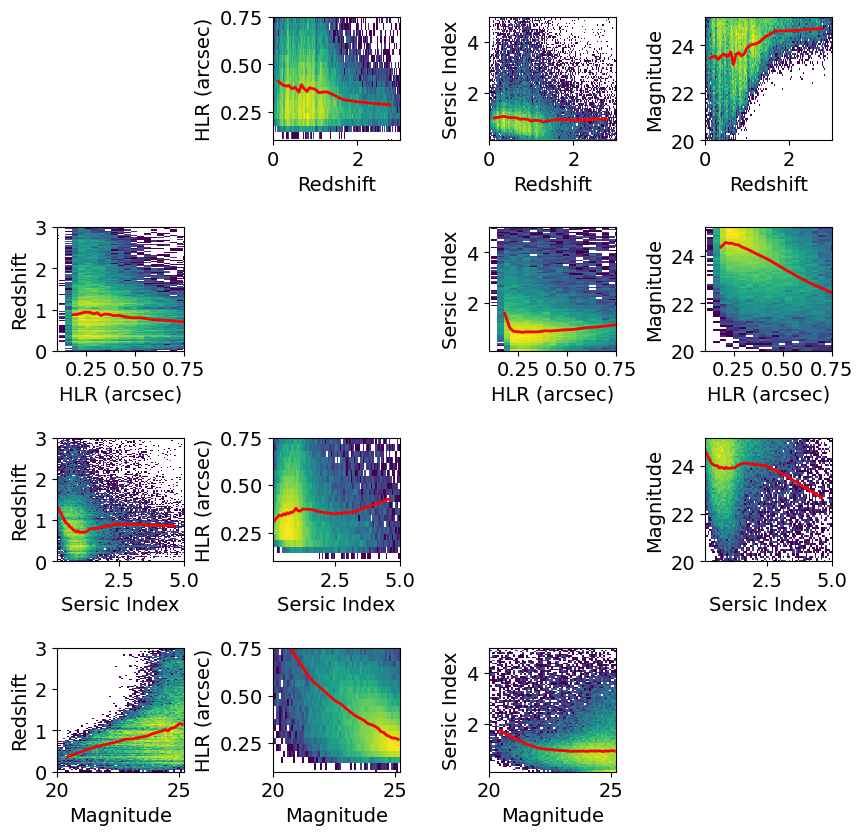

In [39]:
num = 20

fig = plt.figure(figsize = (10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.7)
for row in range(4):
    for col in range(4):
        
        x = property_list[row]
        y = property_list[col]
        x_varname = varname_list[row]
        y_varname = varname_list[col]
        N = len(x)
        bin_len = N//num
        x_arg = np.argsort(x)
        x_sort = np.sort(x)
        y_sort = y[x_arg]
        x_bin = []
        x_bin_error = []
        y_bin = []
        y_bin_error = []
        for i in range(num):
            x_sub = x_sort[i*bin_len:(i+1)*bin_len]
            y_sub = y_sort[i*bin_len:(i+1)*bin_len]
            x_bin.append(np.median(x_sub))
            y_bin.append(np.median(y_sub))
            x_bin_error.append(np.std(x_sub))
            y_bin_error.append(np.std(y_sub))
            

        if (row*4+col+1) not in (1,6,11,16):
            ax = plt.subplot(4,4,row*4+col+1)
            plt.hist2d(property_list[row],property_list[col],bins= (binnum_list[row],binnum_list[col]),norm = mpl.colors.LogNorm())
            plt.plot(x_bin, y_bin,color = 'red',linewidth = 2)
            plt.xlabel(varname_list[row])
            plt.ylabel(varname_list[col])
            plt.xlim(range_list[row])
            plt.ylim(range_list[col])
        #plt.show()


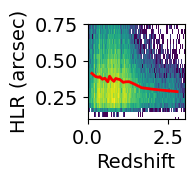

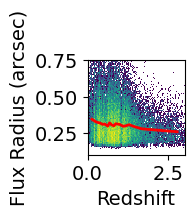

(0.0, 2.0)

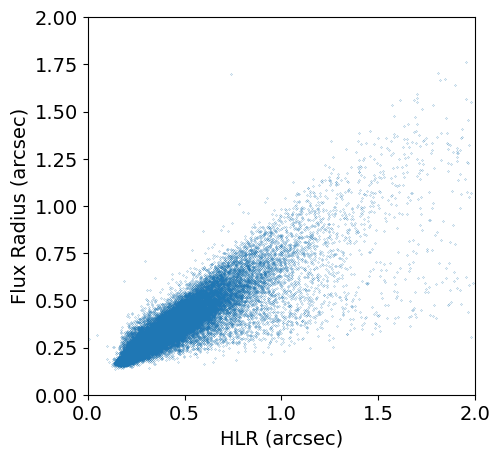

In [56]:
figure = plt.figure(figsize = (5,5))
HLR = ana.df['hlr']
flux_radius = ana.df['flux_radius']
plt.scatter(HLR*0.03,flux_radius*0.03, s = 0.01)
plt.xlabel('HLR (arcsec)')
plt.ylabel('Flux Radius (arcsec)')
plt.xlim([0,2])
plt.ylim([0,2])

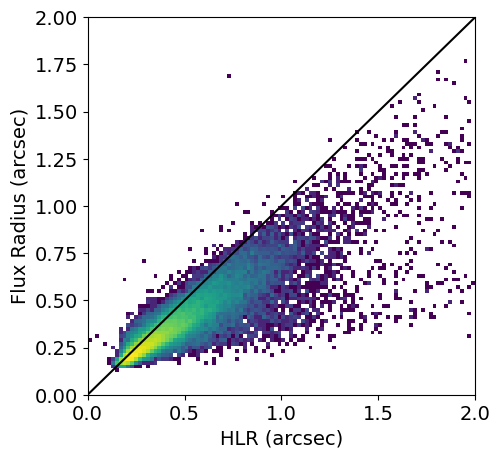

In [66]:
figure = plt.figure(figsize = (5,5))
plt.hist2d(HLR*0.03,flux_radius*0.03, range = [[0,2.0], [0,2.0]], bins = (100,100), norm = mpl.colors.LogNorm())
plt.plot([0,3], [0,3] , color = 'black')
plt.xlabel('HLR (arcsec)')
plt.ylabel('Flux Radius (arcsec)')
plt.show()

In [300]:
mrankdf = ana.df.sort_values(by=["m"])
mrankdf.head(400)

,index,true_shear,truth_kurtosis,model_kurtosis,R_base,e_base,R_mod,e_mod,IDENT,RA,DEC,MAG,BAND,WEIGHT,GAL_FILENAME,PSF_FILENAME,GAL_HDU,PSF_HDU,PIXEL_SCALE,NOISE_MEAN,NOISE_VARIANCE,NOISE_FILENAME,stamp_flux,flux_radius,zphot,use_bulgefit,sersicn,g_base,g_mod,m
1724,41945,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.9965341711532745, 0.05428191147314049, 0.05...","[-0.0006179652003230423, -0.1483706840672949]","[0.995847000241274, 0.054536499566702756, 0.06...","[-0.000569263367437119, -0.14858965228280804]",1331,149.453115,2.538705,24.160000,F814W,0.64514,real_galaxy_images_25.2_n42.fits,real_galaxy_PSF_images_25.2_n42.fits,945,945,0.03,0.000023,0.000006,acs_I_unrot_sci_20_cf.fits,5.636746,6.117918,0.3627,0,1.000670,-0.000681,-0.000627,-0.080386
1006,35549,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.026190525537777502, -1.2448859006169337e-06...","[-4.0671218575395885e-05, -0.00035593893174301...","[0.08695888426191237, -1.2856084047102503e-06,...","[-3.8151728249113494e-05, -0.0003371615991286408]",7756,149.504227,2.787935,23.621000,F814W,0.60698,real_galaxy_images_25.2_n36.fits,real_galaxy_PSF_images_25.2_n36.fits,549,549,0.03,0.000125,0.000006,acs_I_unrot_sci_20_cf.fits,8.836478,10.141542,0.4802,0,0.855032,-0.000044,-0.000041,-0.064139
215,22115,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.003363052621785693, -1.0575322278039839e-07...","[-0.00039602680970466053, -0.0001785949180530552]","[0.0671822323425469, -1.9377970624472182e-07, ...","[-0.0003739529104174985, -0.00016902672295929116]",706855,150.009711,2.140073,24.770000,F814W,0.62106,real_galaxy_images_25.2_n23.fits,real_galaxy_PSF_images_25.2_n23.fits,115,115,0.03,0.000072,0.000007,acs_I_unrot_sci_20_cf.fits,2.910982,8.443708,1.0400,0,0.734855,-0.000429,-0.000404,-0.057922
2561,14374,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[1.1331899612634726, -0.11447115650434214, -0....","[0.0005135763916599314, -0.31821132626790183]","[1.1330028842278475, -0.11473075287794787, -0....","[0.0004855589210906815, -0.3187221360307858]",129566,150.309992,1.986203,24.129000,F814W,0.66338,real_galaxy_images_25.2_n15.fits,real_galaxy_PSF_images_25.2_n15.fits,374,374,0.03,0.000028,0.000007,acs_I_unrot_sci_20_cf.fits,5.588107,4.675303,1.1860,0,0.907490,0.000531,0.000500,-0.057095
214,22115,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.0033966476475381737, -2.0245322014157425e-0...","[0.00044905698758228405, 0.00017897935866766513]","[0.06721129057470603, -2.821188402004791e-07, ...","[0.0004248192723304455, 0.00016895536721568078]",706855,150.009711,2.140073,24.770000,F814W,0.62106,real_galaxy_images_25.2_n23.fits,real_galaxy_PSF_images_25.2_n23.fits,115,115,0.03,0.000072,0.000007,acs_I_unrot_sci_20_cf.fits,2.910982,8.443708,1.0400,0,0.734855,0.000486,0.000459,-0.056162
1197,35654,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.03192563027894801, -0.00010504967868662542,...","[-0.003564714164258164, -0.006108264473395548]","[0.091943627992315, -9.087989104915664e-05, -9...","[-0.0033753614979181498, -0.0057846825543871085]",103611,150.169520,2.054107,24.356001,F814W,0.59328,real_galaxy_images_25.2_n36.fits,real_galaxy_PSF_images_25.2_n36.fits,654,654,0.03,0.000066,0.000006,acs_I_unrot_sci_20_cf.fits,4.569418,12.204524,0.3629,0,0.589920,-0.003862,-0.003649,-0.055313
1196,35654,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.032201277964833915, -0.00012332766922201407...","[0.004191926131986095, 0.006106318600247319]","[0.09218338424316959, -0.00010674790681714126,...","[0.003970112391614253, 0.0057825310730589535]",103611,150.169520,2.054107,24.356001,F814W,0.59328,real_galaxy_images_25.2_n36.fits,real_galaxy_PSF_images_25.2_n36.fits,654,654,0.03,0.000066,0.000006,acs_I_unrot_sci_20_cf.fits,4.569418,12.204524,0.3629,0,0.589920,0.004542,0.004292,-0.055108
1011,20543,"galsim.Shear(g1=0.01,g2=0.0)",2.088971,2.092212,"[0.03751368289656989, -9.857246146291552e-05, ...","[-0.006679219428587866, -0.003120320457871419]","[0.09679946501286672, -8.5

In [89]:
namelist = ['shear0d002','shear0d004','shear0d006','shear0d008','shear0d01','shear0d012']
shear_list = []
bias_list = []
bias_std_list = []
for i in range(len(namelist)):
    name = namelist[i]
    print name
    filename = "Outputs252/"+"kol1d1"+"/"+"kol1d1"+name+".pkl"
    this_df = pd.read_pickle(filename)[0:5000]
    this_ana = analysis(dir_cat+cat_file_name, dir_cat+catparam_file_name, this_df)
    this_ana.add_everything_to_df()
    this_ana.calc_individual_shape()
    
    this_shear = list(this_ana.df["true_shear"])[0].g1
    print this_shear
    shear_list.append(this_shear)
    
    shear_bias, shear_bias_std = this_ana.get_shear_perc_bias(this_ana.df)
    print shear_bias, shear_bias_std
    bias_list.append(shear_bias)
    bias_std_list.append(shear_bias_std)
    


shear0d002
0.002
-0.0030682913929573896 0.000135998235266129
shear0d004
0.004
-0.0027313580657502 0.00013655584385549867
shear0d006
0.006
-0.0029376752001673 0.0001218230695520201
shear0d008
0.008
-0.002929041702225188 0.00012184178947545546
shear0d01
0.01
-0.0030376635380321426 0.000124062098847255
shear0d012
0.012
-0.0029424091149591325 0.00012320327833653395


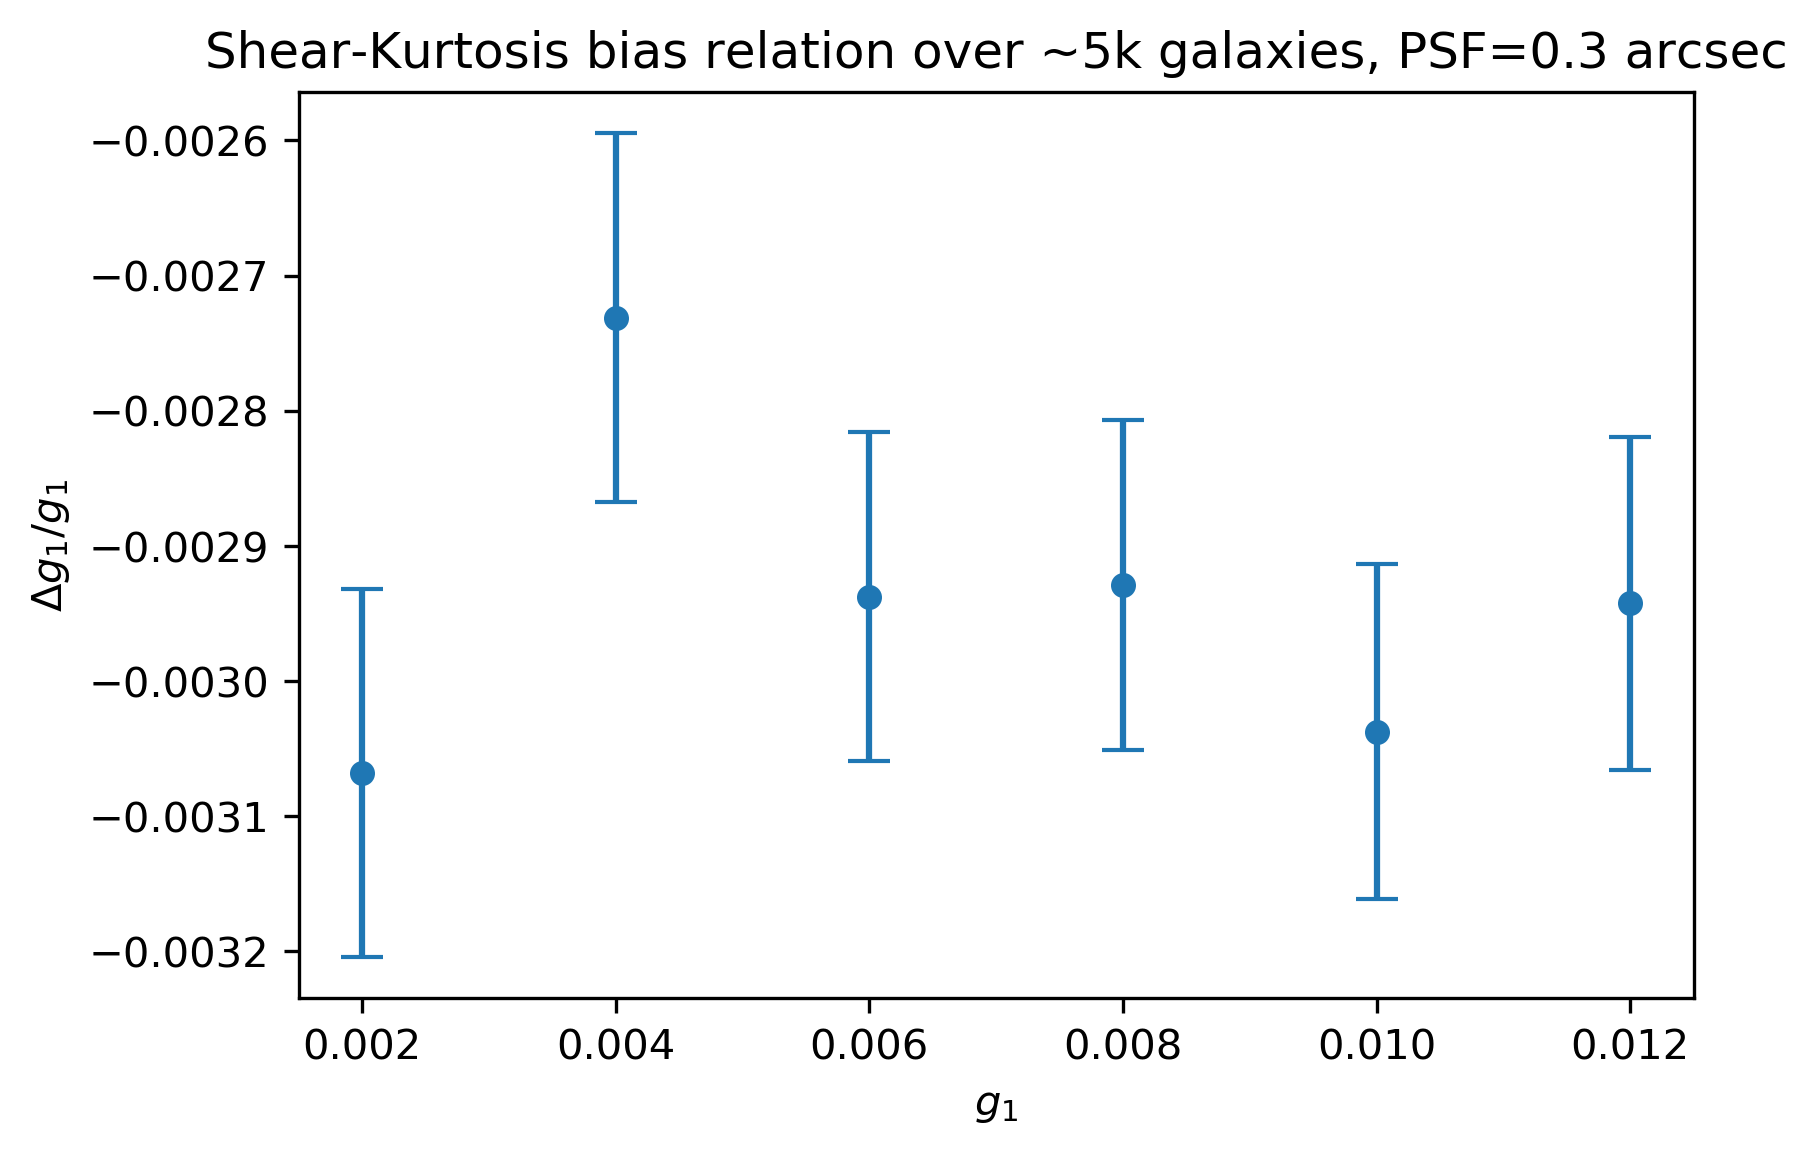

In [90]:
plt.errorbar(shear_list, bias_list, bias_std_list,fmt='o',markersize=5, capsize=5)
plt.xlabel(r"$g_1$")
plt.ylabel(r"$\Delta g_1/g_1$")
plt.title("Shear-Kurtosis bias relation over ~5k galaxies, PSF=0.3 arcsec")
plt.show()

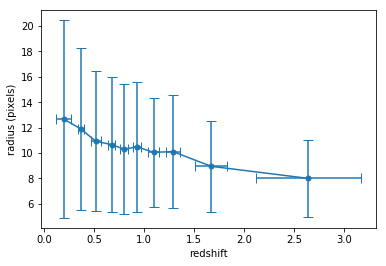

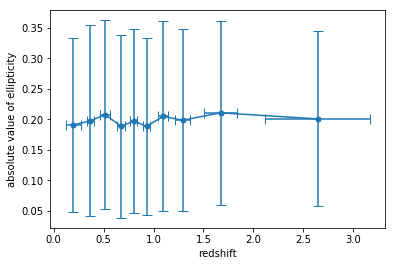

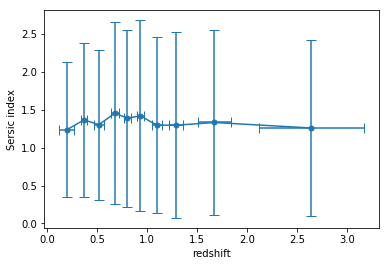

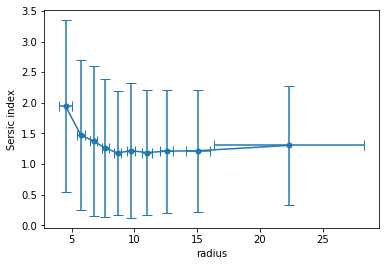

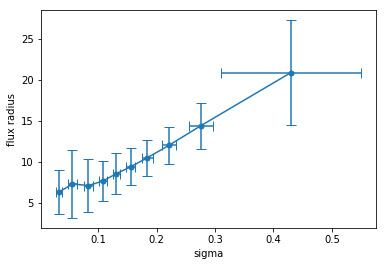

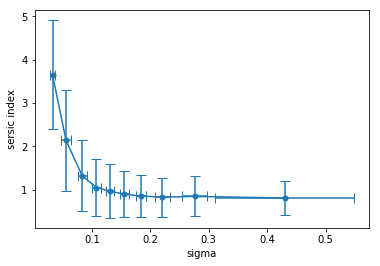

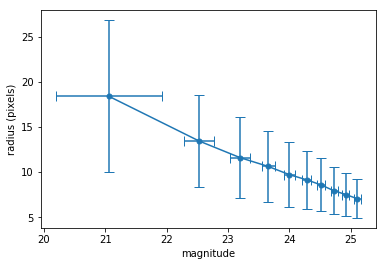

0

In [47]:
binning_plot(photz_list,radius_list,10,"redshift","radius (pixels)")
binning_plot(photz_list,np.abs(gbase_list), 10, "redshift", "absolute value of ellipticity")
binning_plot(photz_list,sersicn_list, 10, "redshift", "Sersic index")
binning_plot(radius_list,sersicn_list, 10, "radius", "Sersic index")
binning_plot(galsig_list,radius_list, 10, "sigma", "flux radius")
binning_plot(galsig_list,sersicn_list, 10, "sigma", "sersic index")
binning_plot(magnitude_list,radius_list,10,"magnitude","radius (pixels)")


[149.43692  149.602581 149.740949 149.870893 149.997601 150.116733
 150.232388 150.356999 150.478972 150.610908 150.790288]
bin  0
bin  1
bin  2
bin  3
bin  4
bin  5
bin  6
bin  7
bin  8
bin  9


Text(0,0.5,'bias(shear)/bias(kurtosis)')

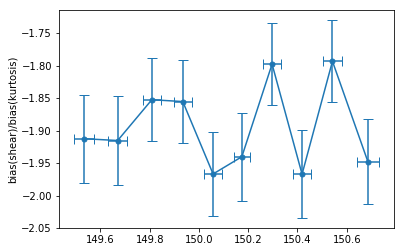

In [357]:
slope, RA, slope_err, RA_err = ana.bin_by("RA", 10 , by_num = True,bootstrap = True)
plt.errorbar(np.array(RA) ,slope,xerr = np.array(RA_err), yerr =slope_err,  fmt="o-", markersize=5, capsize=5)
#plt.xlabel("RA")
plt.ylabel("bias(shear)/bias(kurtosis)")

Claim: RA-bias should be a perfect null test, but we still see > 33 % data points that are out of fitting (suppose fit is just a horizontal line...).

In [28]:
q_list = np.array(ana.df['q'])
e_list = np.array(list(ana.df["e_base"]))
e_abs = np.sqrt(e_list[:,0]**2 + e_list[:,1]**2)

In [56]:
print 1-q_list[::2][:10]
print e_abs[::2][:10]

list1 = 1-q_list[::2]
list2 = e_abs[::2]
list1updown = []
list2updown = []
for i in range(5000):
    if list1[i+1]-list1[i]>0:
        list1updown.append(1)
    else:
        list1updown.append(0)
    if list2[i+1]-list2[i]>0:
        list2updown.append(1)
    else:
        list2updown.append(0)
    

[0.64215437 0.46617412 0.51061039 0.57165777 0.62513293 0.58752499
 0.58194175 0.63729836 0.64391044 0.62387601]
[0.38856447 0.29015884 0.33021857 0.32464144 0.41081656 0.40563915
 0.34085941 0.45735876 0.46461248 0.36805746]


In [57]:
print np.mean(np.array(list1updown)==np.array(list2updown))

0.502


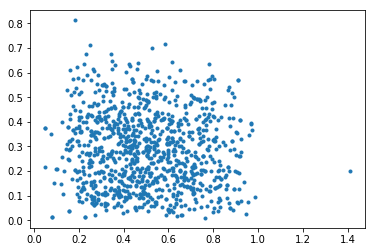

In [41]:
plt.plot(q_list[::2][:1000],e_abs[::2][:1000],'.')

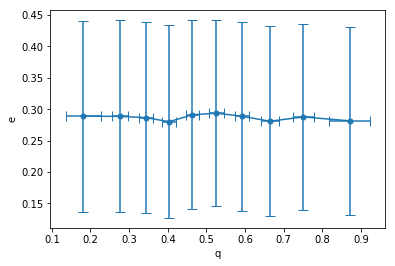

0

In [32]:

binning_plot(q_list,e_abs, 10, "q", "e")


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
a = np.random.uniform(0,1,1000)
print(np.mean(a), np.std(a))

(0.5039657677775667, 0.2893230909786246)


<ErrorbarContainer object of 3 artists>

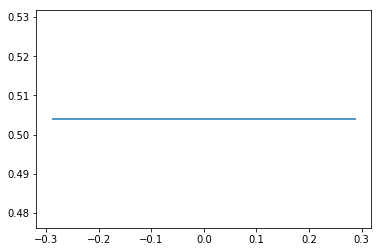

In [5]:
plt.errorbar([0],[np.mean(a)], xerr = [np.std(a)])

In [89]:
kol1 = galsim.Kolmogorov(half_light_radius = 0.3)
image1 = kol1.drawImage(scale = 0.2)
sigma1 = galsim.hsm.FindAdaptiveMom(image1).moments_sigma*0.2
print(sigma1)


kol2 = galsim.Kolmogorov(half_light_radius = 0.35)
image2 = kol2.drawImage(scale = 0.2)
sigma2 = galsim.hsm.FindAdaptiveMom(image2).moments_sigma*0.2
print(sigma2)
print(sigma2/sigma1, 0.35/0.3)

0.244562673569
0.2826816082
(0.34675971284796536, 1.1666666666666667)


In [ ]:
image1